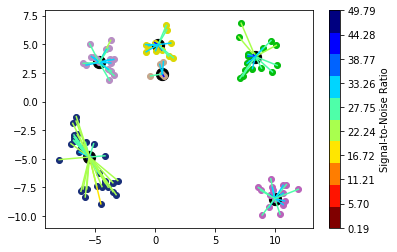

0.6954362392425537
{'Cluster Head': 'client84', 'Members': ['client6', 'client7', 'client13', 'client40', 'client41', 'client48', 'client52', 'client60', 'client62', 'client72', 'client80', 'client82', 'client88', 'client92', 'client96', 'client99'], 'SNR': [21.67786717032239, 24.310789863926825, 20.397924613355322, 25.58576955194027, 25.899675036205423, 32.1731215863105, 27.404944649802797, 24.382692187470944, 16.99094429817887, 31.1833207898107, 26.55866027753313, 42.304692701731184, 28.396937819812113, 23.639144999872173, 34.37967448508517, 28.06917033822431], 'CSI': [0.05751168061428247, 0.8255347305873814, 0.5133115148067788, 0.5621021873741089, 0.3446631851888009, 0.4333055830444814, 0.7145987120503546, 0.17943234459723367, 0.31462102190828367, 0.8950559926027499, 0.2953095397530189, 0.3537151929016945, 0.5353630022572764, 0.596489035632758, 0.5125962311765618, 0.9532869017802265]}


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import numpy as np
from Dataset import load_dataset, getImage
from utils import averageModels
from utils import averageModelscluster
import random
import math
import matplotlib.pyplot as plt
from ipynb.fs.full.K_clusters import cluster_former
from copy import deepcopy

In [2]:
P=2 #signal power threshold
#stream = BitStream()
#random.seed(10)
key=[]
for i in range (10000): #generating a random password to activate training (Pilot signal)
    temp=random.randint(0,1)
    key.append(temp)

key1=[0]*len(key)
for i in range (len(key)):   #bpsk modulation
    if(key[i]==1):
        #print("yay")
        key1[i]=-math.sqrt(P)
    else:
        key1[i]=math.sqrt(P)

#print(key)
        
key_np=np.array(key1)

In [3]:
class Arguments():
    def __init__(self):
        self.images = 10000
        self.clients = 50
        self.rounds = 200
        self.epochs = 3
        self.local_batches = 64
        self.lr = 0.01
        self.C = 1 #fraction of clients used in the round
        self.drop_rate = 0 #fraction of devices in the selected set to be dropped for various reasons
        self.torch_seed = 0 #same weights and parameters whenever the program is run
        self.log_interval = 64
        self.iid = 'noniid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = True
        self.numclusters=4

args = Arguments()

In [4]:
#checking if gpu is available
#use_cuda = args.use_cuda and torch.cuda.is_available()
use_cuda=False
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

hook = sy.TorchHook(torch)
me = hook.local_worker
clients = []

#generating virtual clients
for i in range(args.clients):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})
#print(clients)

In [5]:
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid) #load data

for inx, client in enumerate(clients):  #return actual image set for each client
    trainset_ind_list = list(train_group[inx]) 
    client['trainset'] = getImage(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getImage(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images #useful while taking weighted average


/home/test/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [6]:
#load dataset for global model (to compare accuracies)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.MNIST('./', train=False, download=True, transform=transform)
# global_test_dataset = torch.utils.data.random_split(global_test_dataset, [10000, len(global_test_dataset)-10000])[0]
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

In [7]:
"""class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 10, 5, 1)
        self.fc1 = nn.Linear(4*4*10, 50) #10 iid #50 non iid
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #x=self.quant(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*10
                   )
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) """

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
def fedprox(params,global_params):
    global_param=[]
    ind=0
    for gp in global_params:
        global_param.append(gp)
    for p in params:
    #                 print(p.grad)
        lr=0.001
        mu=0.1
        if(p.grad is None):
            continue
        grad=p.grad.data #batch gradients
        p.data.sub_(lr,(grad+mu*(p.data.clone()-global_param[ind].data.clone())))
        ind+=1
    return(p)

In [9]:
def ClientUpdate(args, device, client,key_np,key,snr,csi,mu,head):
    gc=False
    client['model'].train()
    #simulating a wireless channel
    poptim=max((1/mu-1/csi),0)
    #print(mu,csi)
    print("Power Allocated=",poptim)
    print("CSI=",csi)
    
    snr__=10**(snr/10)
    
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    #print(x)
    y=math.sqrt(absh*absh-x*x)
    #x=x*100
    #y=y*100
    #x=random.random()
    #y=random.random()
    #snr=10*math.log(poptim/(std*std),10)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
    
    #print(x,y)
    h=complex(x,y)
    #std=math.sqrt(abs(h)/csi)
    #snr=poptim/(std*std)
    #print(std)
    print("SNR=",snr)
    #print("csi",abs(h)/(std*std))
    
    
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data

    
    #print(client['model'].conv1.weight.size)
    client['model'].send(client['hook'])
    head['model'].send(client['hook'])
    print("Client:",client['hook'].id)
    
    key_np_received=h*key_np+(np.random.randn(len(key_np))*std*2)
    #print(key_np_received)
    key_np_received=(key_np_received/(h)).real
    
    for o in range (len(key_np_received)):  #demodulation bpsk
        if(key_np_received[o]>=0):
            key_np_received[o]=0
        else:
            key_np_received[o]=1
    
    key_np_received=key_np_received.tolist()
    key_np_received = [int(item) for item in key_np_received]
    #key_np=key_np.tolist()
    
    
    if(sum(np.bitwise_xor(key,key_np_received))/len(key)==0 and poptim>0): #...............................................checking if channel is good enough for transmission by checking BER..................................#
        gc=True #considering the client model for training
        for epoch in range(1, args.epochs + 1):
            for batch_idx, (data, target) in enumerate(client['trainset']): 
                data = data.send(client['hook'])
                target = target.send(client['hook'])
                #client['optim'].zero_grad()
                #train model on client
                data, target = data.to(device), target.to(device) #send data to cpu/gpu (data is stored locally)
                output = client['model'](data)
                loss = F.nll_loss(output, target)
                loss.backward()
                #client['optim'].step()
                params=client['model'].parameters()
                gp=head['model'].parameters()
                params=fedprox(params,gp) 
                
                if batch_idx % args.log_interval == 0:
                    loss = loss.get() 
                    print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        client['hook'].id,
                        epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                        100. * batch_idx / len(client['trainset']), loss))
    else:
        print("Poor Channel, client not taken for averaging in this round")
            
                    
    client['model'].get()
    head['model'].get()
    # print()
         #CHANGE
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
    #CHANGE ENDS
    print()
    return gc

In [10]:
def test(args, model, device, test_loader, name,fed_round):
    model.eval()    #no need to train the model while testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if(use_cuda and fed_round==0):
                data,target=data.cuda(),target.cuda()
                #model.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return([100. * correct / len(test_loader.dataset),test_loss])

In [11]:
torch.manual_seed(args.torch_seed)

In [12]:
def distort(neighbours,snrs):
    ind=0
    poptim=2
    csi=random.random()
    distorted_models=[]
    for client in neighbours:
        snr=snrs[ind]
        ind+=1
        snr__=10**(snr/10)
        absh=csi*poptim/snr__
        x=random.uniform(0,absh)
        y=math.sqrt(absh*absh-x*x)
        std=math.sqrt(poptim/snr__*absh*absh) #channel noise
        h=complex(x,y)
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
        
        distorted_models.append(client)
    return(distorted_models)
        

In [13]:
def decentralized(clients,snrs,weights):
    big_daddy_of_distorted_models=[]
    for client in clients:
        distorted_models=[]
        snr_list=[]
        for snr in snrs:
            if(client['hook'].id in snr):
                snr_list.append(snr[2])
        neighbours_c = [x for x in clients if x != client]
        neighbours={}
        jjj=[jkl for jkl in range(len(neighbours_c))]
        
        dictionary = dict(zip(jjj, neighbours_c))
        #for jjj in range(len(neighbours_c)):
        #   neighbours[jjj].append(neighbours_c[jjj])
        distorted_models=distort(neighbours,snr_list)
        distorted_models.append(client)
        big_daddy_of_distorted_models.append(distorted_models)
    
    
    weight_final1=[]
    for oho in big_daddy_of_distorted_models:
        weight_final=[]
        for comeon in oho:
            for w in weights:
                if(comeon['hook'].id==w[0]):
                    weight_final.append(w[1])
        weight_final1.append(weight_final)
    
    final_heads=[]
    nets=[]
    ind=0
    for client in clients:
        for oof in big_daddy_of_distorted_models:
            if(client==oof[0]):
#                 print(client)
#                 print("shut up")
#                 print(distorted_models)
#                 print("shut up")
#                 print(weight_final1)
                
                overall=Net()
                overall=averageModelscluster(overall,distorted_models,weight_final1[ind])
                client['model'].load_state_dict(overall.state_dict())
                ind+=1
                final_heads.append(client)
                nets.append(overall)
    
    return(final_heads,nets)
        
            
            

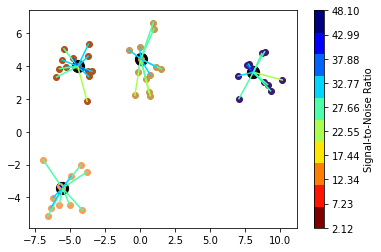

0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.289337


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/generic/frameworks/hook/hook.py:165: UserWarning: This overload of sub_ is deprecated:
	sub_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	sub_(T

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.089245
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.627793

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.276023
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.681459
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.244018

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.229549
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.727454
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.370977

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.337960
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.053160
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.485008

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

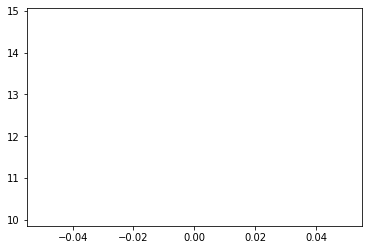

ROUND 0
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298272


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.982358
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.997666

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.278821
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.014636
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.640020

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.290168
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.038140
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.567015

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304065
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.077177
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.550412

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

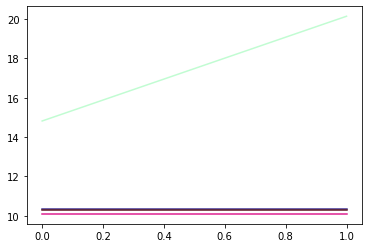

ROUND 1
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.292636


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.071026
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.905105

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.280519
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.670541
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.777598

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.322930
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.964434
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.427254

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298299
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.065373
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.757367

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

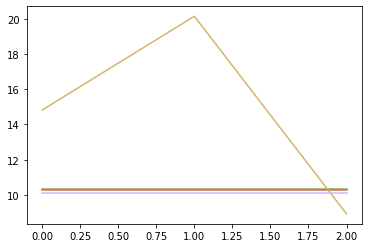

ROUND 2
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.263819


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.941829
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.658600

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.287451
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.721390
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.534842

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.341780
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.801343
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.250762

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.280919
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.941248
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.593145

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

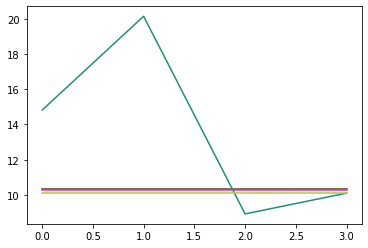

ROUND 3
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.250294


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.799338
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.489294

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.271097
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.600882
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.208244

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.379167
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.600151
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.591547

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.265239
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.736320
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.563427

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

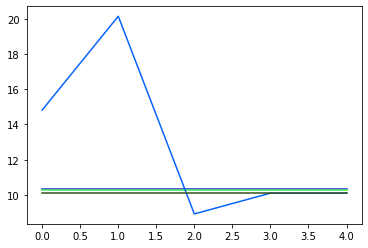

ROUND 4
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.259653


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.712684
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.394222

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.253604
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.397605
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.159418

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.394315
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.560932
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.140520

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.290766
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.796802
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.430436

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

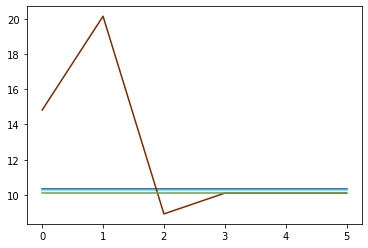

ROUND 5
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.223022


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.628210
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.348312

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.269386
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.382985
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.007855

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.428188
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.419047
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.134784

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.275658
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.718184
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.431383

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

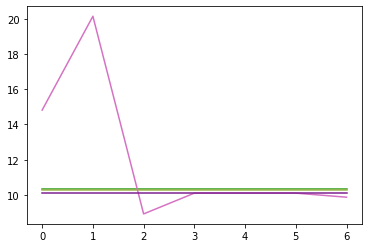

ROUND 6
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.213569


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.562785
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.347560

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.254564
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.212954
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.087222

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.415187
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.342012
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.027991

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.215190
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.621652
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.409499

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

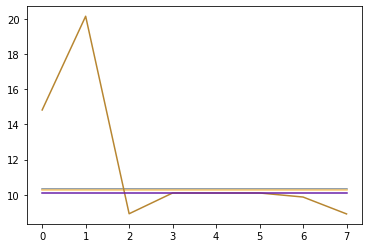

ROUND 7
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.259032


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.534203
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.577140

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.230103
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.217234
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.184629

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.443964
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.217257
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.029557

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.235128
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.608079
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.376291

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

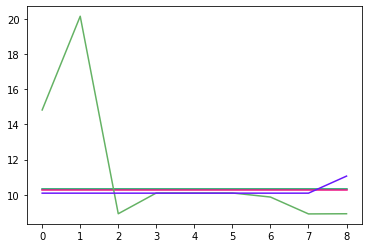

ROUND 8
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.244179


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.523685
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.407571

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.251472
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.211421
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.978285

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.404110
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.182050
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.037046

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.231867
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.547092
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.333077

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

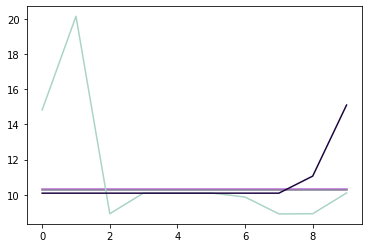

ROUND 9
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.200147


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.507420
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.181995

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.224114
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.067672
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.895046

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.435228
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.122788
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.422828

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.247891
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.480662
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.069013

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

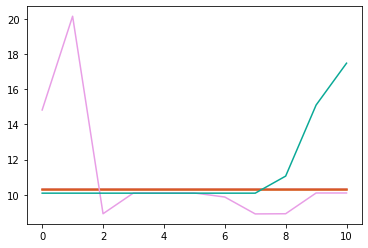

ROUND 10
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.193167


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.344535
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.060725

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.231156
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.049162
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.103004

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.442479
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.225020
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.313026

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.258703
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.405687
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.069868

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

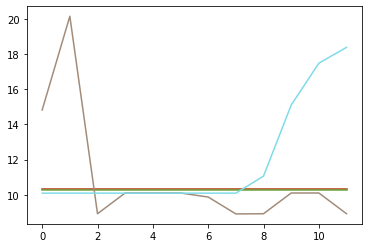

ROUND 11
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.206513


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.305816
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.940633

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.213696
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.174016
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.957736

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.412065
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.120111
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.632469

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300684
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.318044
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.116615

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

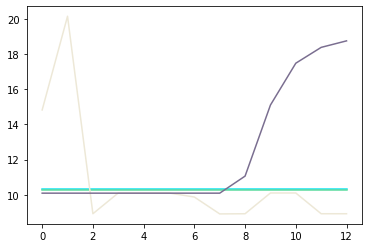

ROUND 12
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.181715


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.251995
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.847729

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.270997
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.934832
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.508758

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.434216
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.112291
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.017465

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.262330
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.291424
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.955298

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

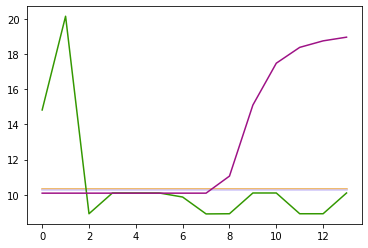

ROUND 13
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.191305


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.416725
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.968269

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.216789
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.869894
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.030803

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.408339
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.135327
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.168501

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291134
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.195088
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.828342

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

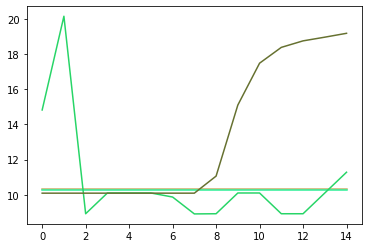

ROUND 14
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.101681


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.279780
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.932190

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.248005
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.894272
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.765270

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.455961
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.126057
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.937220

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.193830
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.182344
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.663176

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

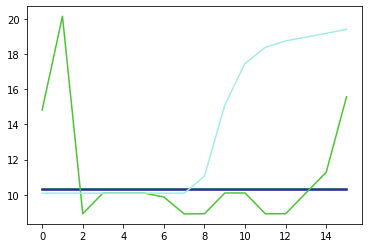

ROUND 15
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.181010


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.291972
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.229771

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.166397
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.941053
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.719509

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.462565
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.962441
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.056490

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.241038
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.299329
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.773795

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

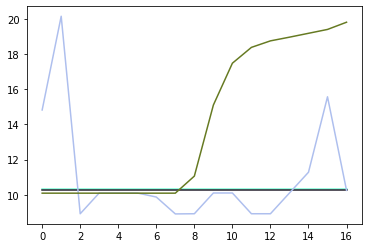

ROUND 16
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.096239


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.278038
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.050600

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.179054
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.796322
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.641248

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.472608
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.025948
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.878126

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.217441
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.000972
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.283253

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

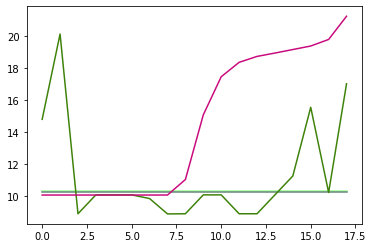

ROUND 17
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.191199


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.149900
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.849806

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.169485
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.796622
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.030525

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.437470
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.149784
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.937680

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.196021
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.978877
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.548275

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

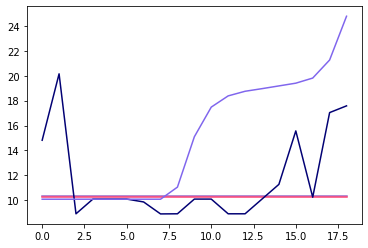

ROUND 18
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.065418


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.026991
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.901319

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.115346
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.835755
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.984837

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.435262
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.137016
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.051345

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.242462
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.069476
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.249097

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

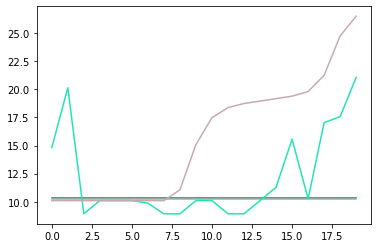

ROUND 19
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.145638


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.995258
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.099361

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.146906
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.615250
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.478827

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.427384
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.958945
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.742997

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.229315
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.941707
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.434265

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

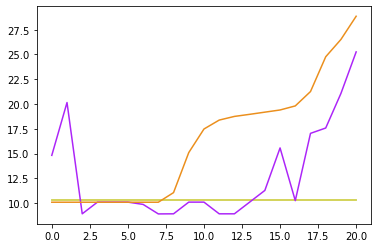

ROUND 20
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.087579


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.979241
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.832770

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.142167
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.608993
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.769441

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.411573
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.029791
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.768423

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.094905
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.743317
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.678101

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

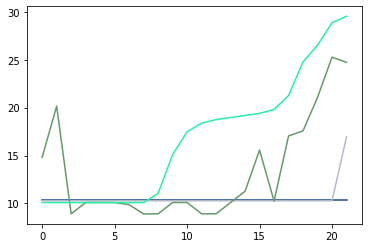

ROUND 21
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.126651


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.949010
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.585397

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.148866
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.698777
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.860594

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.435773
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.634882
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.808476

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.202237
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.740460
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.157678

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

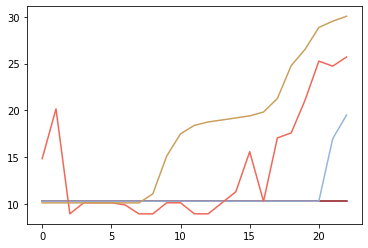

ROUND 22
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.134407


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.837156
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.668959

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.074694
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.590424
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.752747

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.436442
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.956565
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.656523

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.215691
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.533720
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.414181

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

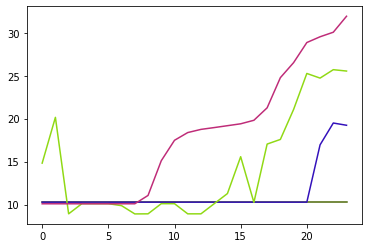

ROUND 23
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.989011


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.822240
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.401091

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.067297
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.594726
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.678389

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.374491
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.747499
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.683462

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.159072
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.514892
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.113236

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

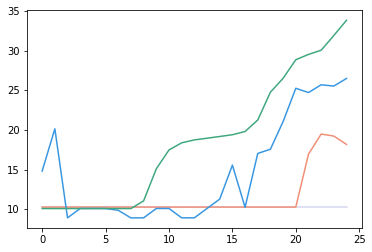

ROUND 24
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.029377


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.672587
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.775281

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.997017
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.417619
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.587702

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.340119
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.838950
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.608064

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.179728
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.469891
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.175781

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

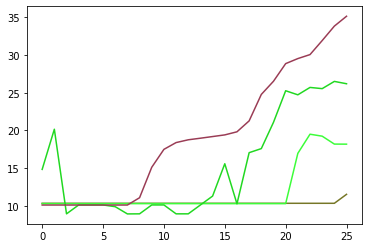

ROUND 25
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.046717


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.936671
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.792472

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.938985
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.573567
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.550629

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.387759
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.731653
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.671202

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.142634
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.376157
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.416986

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

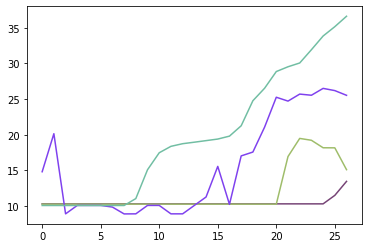

ROUND 26
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.976320


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.649873
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.526336

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.972839
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.548545
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.348327

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294774
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.623781
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.970505

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.842582
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.338120
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.116342

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

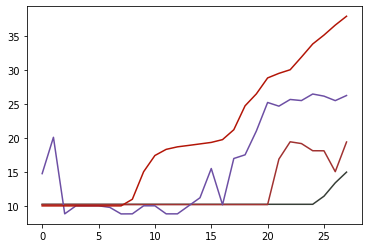

ROUND 27
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.936076


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.580793
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.419759

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.827048
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.356501
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.272695

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.227187
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.786903
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.553275

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.116344
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.323321
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.224775

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

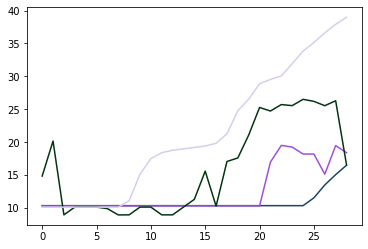

ROUND 28
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.868142


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.403840
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.306394

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.990588
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.395263
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.201127

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304141
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.407900
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.323395

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.045853
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.307162
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.317538

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

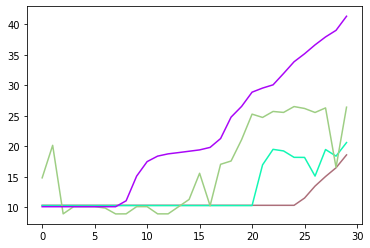

ROUND 29
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.814227


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.525977
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.331947

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.859363
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.240618
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.211778

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.272897
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.298959
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.244709

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.866080
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.514506
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.354891

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

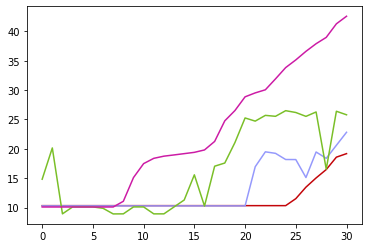

ROUND 30
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.845834


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.467617
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.264740

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.839890
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.251424
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.422101

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.193858
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.326630
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.106534

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.014328
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.218593
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.581412

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

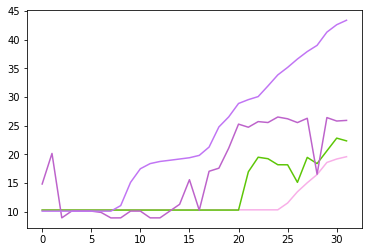

ROUND 31
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.841862


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.550685
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.225081

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.855084
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.376566
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.222592

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.182549
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.379510
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.256843

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.895170
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.141334
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.423356

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

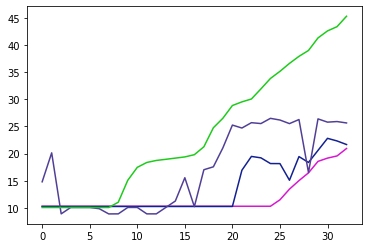

ROUND 32
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.763686


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.600876
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.306205

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.587322
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.201360
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.121211

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.124460
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.256759
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055087

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.024363
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.401722
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.251722

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

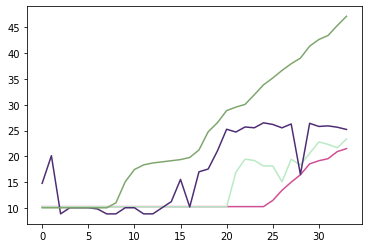

ROUND 33
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.677458


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.285088
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.296677

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.715933
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.284470
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.185705

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.178256
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.339455
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.601715

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.941622
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.543231
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.170241

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

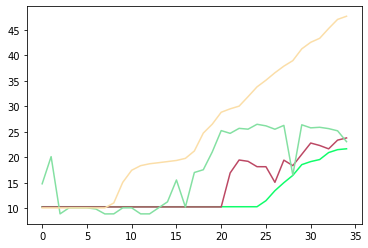

ROUND 34
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.615180


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.231451
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.335430

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.714129
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161991
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.146341

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.144788
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.316475
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.146033

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.934328
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.177968
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.130660

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

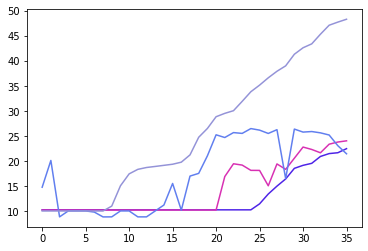

ROUND 35
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.745019


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.290678
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.097809

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.651217
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.167513
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.122097

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.093833
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.336332
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.377643

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.937587
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.146111
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.347637

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

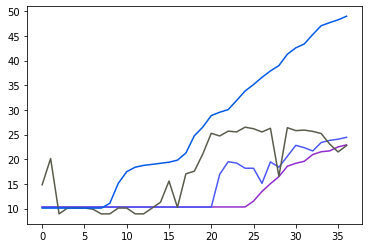

ROUND 36
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.526721


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.509568
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.167117

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.717391
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077756
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.094271

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.188847
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.323004
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.107320

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.819615
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.264730
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.695811

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

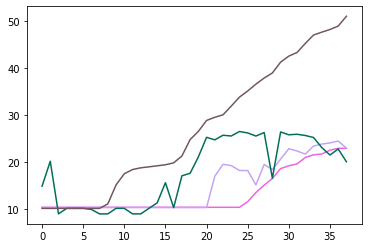

ROUND 37
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.536595


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.264006
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.172464

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.488678
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119542
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.137909

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.086463
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.268062
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.957920

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.848063
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031104
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.128053

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

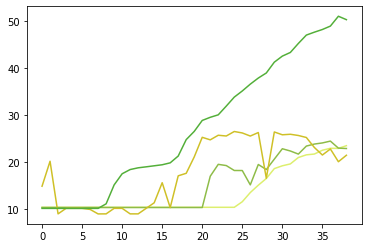

ROUND 38
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.628458


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.361696
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.480137

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.539564
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.286923
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015904

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.069528
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.320761
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.177429

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.944100
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121270
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.122564

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

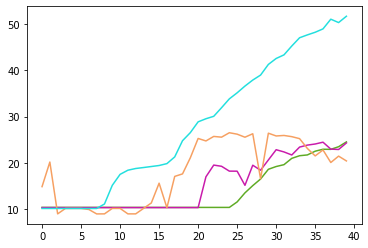

ROUND 39
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.463598


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.312650
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.211188

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.478027
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.152237
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.076870

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.088136
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.247135
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019152

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.806396
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.259328
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.039172

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

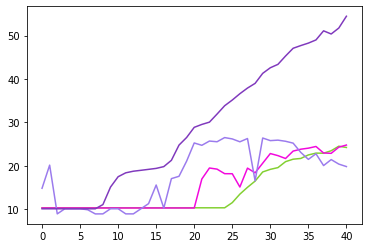

ROUND 40
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.653827


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.737551
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.178082

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.553030
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101403
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.186171

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.973446
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119916
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015678

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.807329
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.259288
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.057054

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

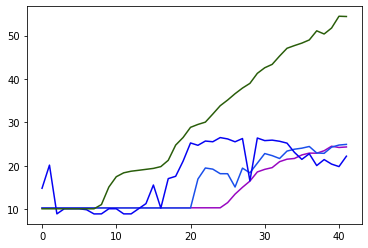

ROUND 41
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.528991


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.299283
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.146669

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.565466
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.108428
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009256

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.883643
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.210519
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.097299

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.671258
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.063500
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.111876

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

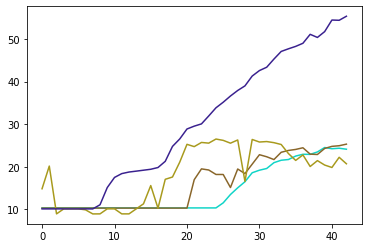

ROUND 42
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.494964


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.187100
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.873084

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.609411
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115835
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.105343

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.010406
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107962
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.025230

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.706445
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081914
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.191067

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

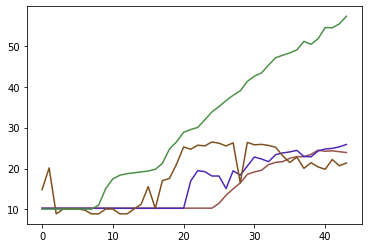

ROUND 43
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.470898


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179054
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.210966

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.645546
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022857
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.029754

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.022915
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197031
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.052865

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.706559
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.201707
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.368269

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

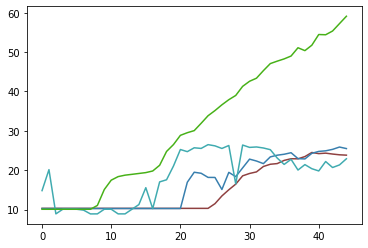

ROUND 44
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.529180


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.294079
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.351265

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.452648
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.206211
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.138614

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.931211
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089519
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.313159

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.684984
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031653
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.138363

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

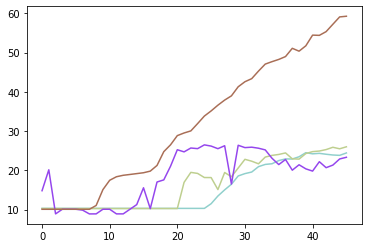

ROUND 45
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.291040


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.274881
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.388374

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.458625
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058191
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.054583

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.867669
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.131511
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.068216

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.707557
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083134
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.185193

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

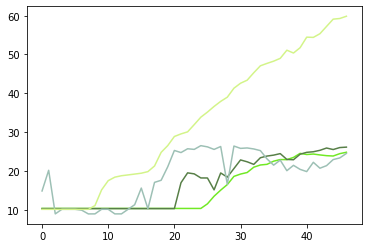

ROUND 46
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.455846


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.166427
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.071133

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.283419
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.241772
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059443

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.911347
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089532
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041802

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.621381
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091267
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.491364

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

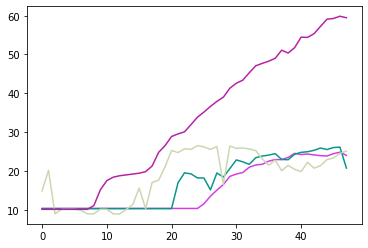

ROUND 47
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.517500


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.209178
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.367083

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.282300
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041165
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.223043

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.880412
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.212278
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.183516

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.515644
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.325794
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.238248

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

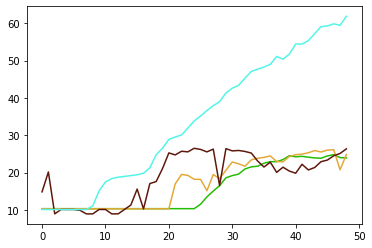

ROUND 48
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.483045


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083502
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.123655

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.591355
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.193651
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.159176

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.953230
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.154416
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.081825

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.626396
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130023
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.214197

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

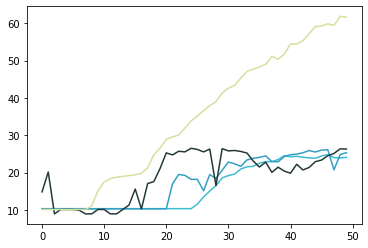

ROUND 49
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.472595


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161903
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.046912

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.398714
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022184
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011410

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.879444
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155817
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.128168

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.751316
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088928
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035706

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

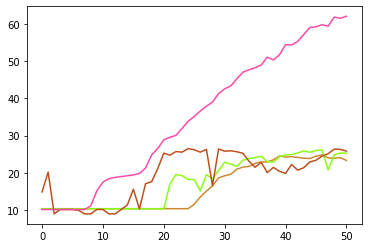

ROUND 50
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.502503


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.439178
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.314699

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.330557
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.149510
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.137619

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.800470
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.243383
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053359

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.651729
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.126218
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.054563

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

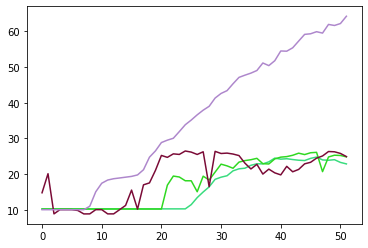

ROUND 51
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.253596


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.380822
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.128933

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.451533
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020931
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.288207

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.777907
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.114213
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.394278

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.634104
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082939
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.162443

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

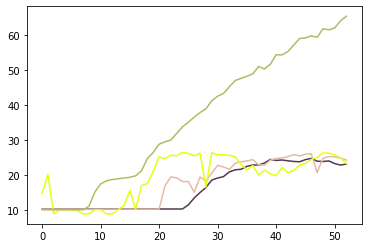

ROUND 52
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.404164


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107242
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.191922

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.280300
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070222
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.121645

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.701867
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.371654
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001685

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.516591
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077716
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029248

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

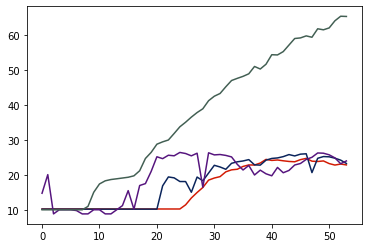

ROUND 53
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.419757


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091631
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.290051

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.308204
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.098302
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.363252

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.645047
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099711
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015531

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.609328
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129157
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.149714

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

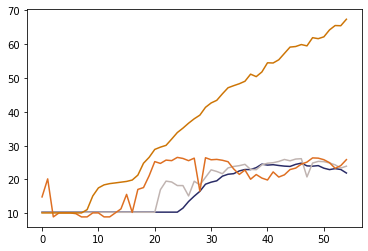

ROUND 54
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.348268


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.230424
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.380686

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.287045
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105865
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.645378

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.832122
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.215814
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.316409

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.524833
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.191826
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.426402

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

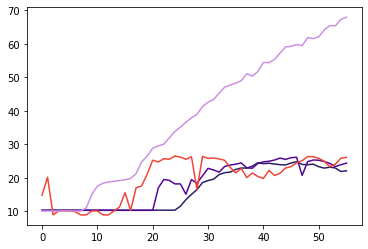

ROUND 55
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.491109


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.254156
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.671017

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.183920
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.124704
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.076154

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.827492
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041379
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053415

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.402050
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.692701
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.117976

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

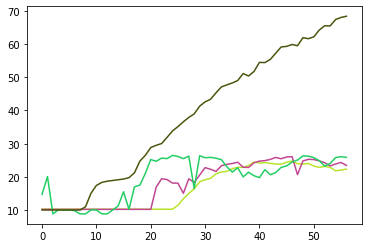

ROUND 56
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.329050


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.163509
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.379203

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.374483
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069214
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.924194

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.912804
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.236757
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.219646

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.467937
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066167
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.071162

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

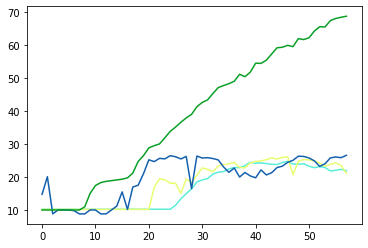

ROUND 57
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.279381


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.118858
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.224167

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.440935
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.098885
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.189277

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.710861
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117177
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.061439

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.438229
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.141346
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.112824

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

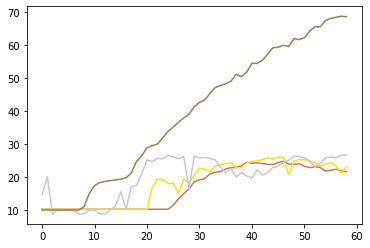

ROUND 58
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.275159


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101233
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.314484

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.227947
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061792
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.112046

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.781141
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.106671
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.033886

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.528625
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085534
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.136062

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

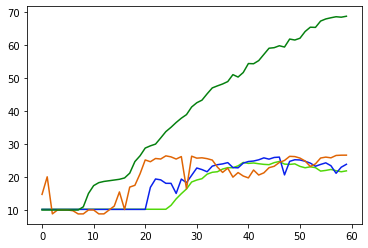

ROUND 59
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.216985


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.212094
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.170151

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.194364
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.384666
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.107674

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.624569
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025596
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036207

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.517037
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.185294
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.572051

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

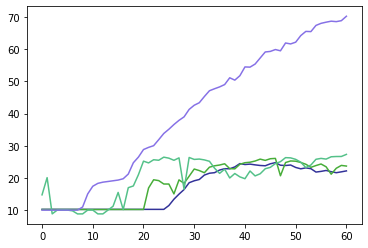

ROUND 60
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.268526


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.265922
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.956140

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.236460
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116243
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.230361

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.781983
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.159471
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.089330

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.451491
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094741
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.160906

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

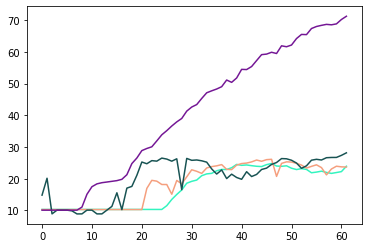

ROUND 61
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.280231


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051512
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.185450

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.088096
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094721
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.082009

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.706880
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060667
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.162056

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.376897
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.660134
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.176552

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

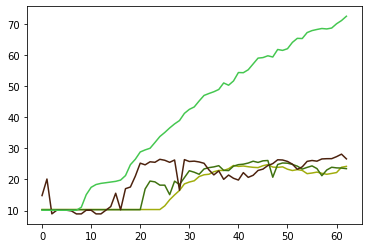

ROUND 62
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.265060


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.246007
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.104041

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.215804
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.131246
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.054688

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.696670
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.128308
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.048306

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.552534
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.124238
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036543

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

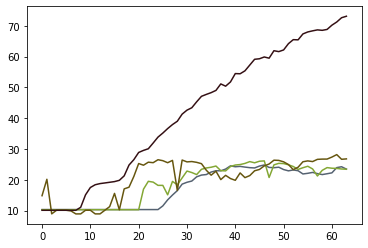

ROUND 63
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.237823


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.205793
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.194601

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.120889
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002569
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002839

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.618892
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092365
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.037818

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.407142
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102312
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.381184

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

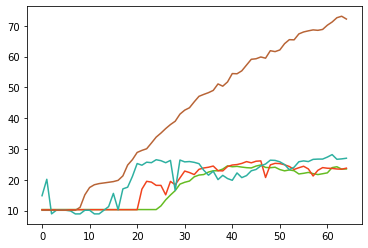

ROUND 64
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.174660


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.148942
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.222519

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.348404
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048192
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.138887

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.673845
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.205150
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.087950

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.382776
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151514
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.073414

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

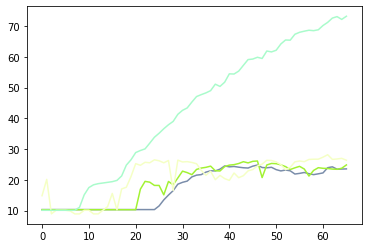

ROUND 65
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.172652


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.196180
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.048854

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.279987
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061140
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.108144

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.803096
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076735
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.150986

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.435289
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079946
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.234385

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

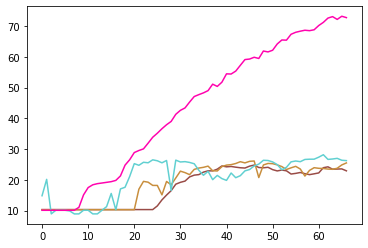

ROUND 66
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.219196


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070102
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.317579

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.172504
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092583
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.065611

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.604194
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042353
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.283950

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.366890
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.343383
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.044081

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

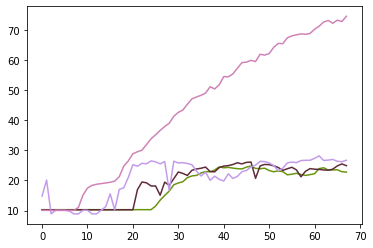

ROUND 67
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.366472


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.166992
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.440605

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.154204
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067258
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.084650

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.632176
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.097781
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.200254

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.403888
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.189521
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.118309

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

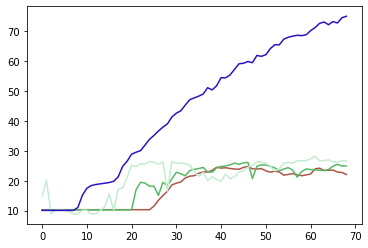

ROUND 68
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.383302


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120112
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.639009

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.210269
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027870
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.115035

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.855961
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083863
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008965

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.331068
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047851
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.099941

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

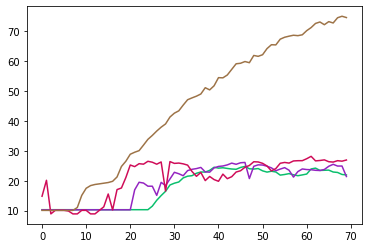

ROUND 69
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.372908


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.331810
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.027609

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.126041
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.152178
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.465165

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.626275
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.203921
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.170931

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.356525
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054538
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030377

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

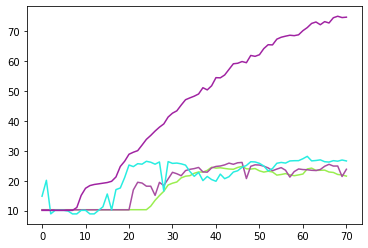

ROUND 70
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.188763


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.341150
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.124079

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.099560
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082942
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.266178

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.669895
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.213043
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004221

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.365398
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012789
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.222871

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

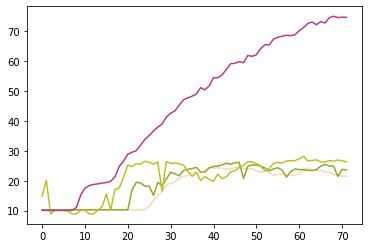

ROUND 71
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.392699


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179328
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.203053

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.108943
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.534241
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.239208

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.522985
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123049
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.048681

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.324492
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078254
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.066676

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

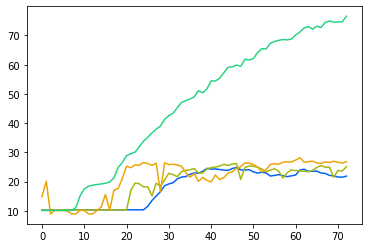

ROUND 72
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.207652


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048321
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.634193

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.194271
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.261260
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.754852

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.802763
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.384348
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.384914

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.259139
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066274
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.087777

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

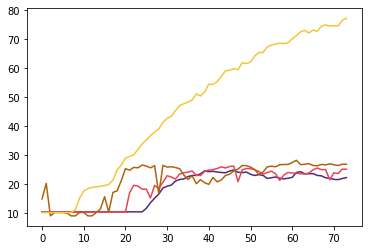

ROUND 73
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.181927


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096985
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.316366

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.151157
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081051
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059019

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.619686
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092482
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.148791

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.169318
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.111518
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018594

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

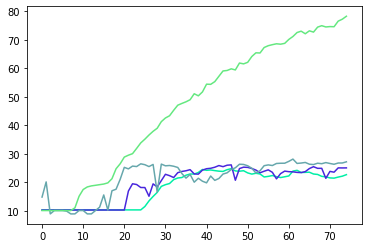

ROUND 74
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.393989


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.176265
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.243873

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.144559
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.237488
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.075576

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.557553
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085033
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.152183

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.318633
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.222804
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.067376

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

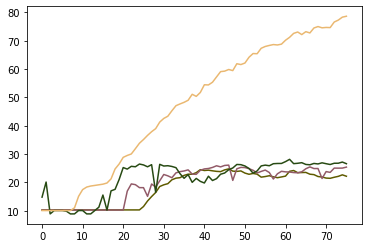

ROUND 75
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.123675


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.230873
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.103198

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.168130
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052341
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.046738

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.696998
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022633
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.216614

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.141966
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.114237
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.191131

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

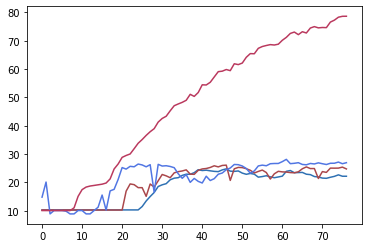

ROUND 76
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.151460


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.141165
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.372943

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.111031
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181295
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.816277

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.430158
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073305
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.295556

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.266485
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.266635
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.034514

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

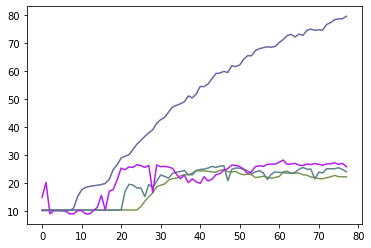

ROUND 77
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.034643


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142348
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.114475

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.164108
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.900393
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.848325

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.430649
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044838
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.433665

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.267616
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069425
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.119203

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

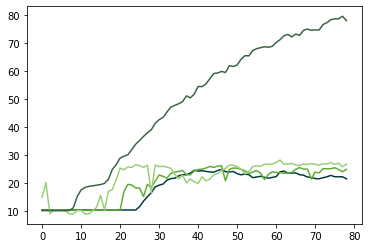

ROUND 78
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.175313


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113678
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.034555

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.086854
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.391696
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.313385

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.511143
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087246
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.184505

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.193004
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160103
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.271060

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

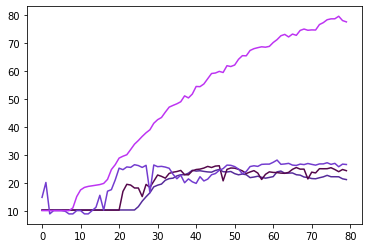

ROUND 79
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.141244


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061724
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.076502

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.358187
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.257785
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.168448

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.547375
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084004
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.118467

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.288667
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081195
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.215990

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

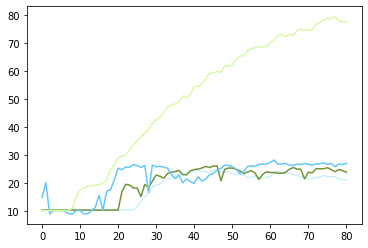

ROUND 80
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.162511


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.125152
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.196251

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.998227
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.291686
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.223271

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.558295
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039403
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.047751

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.243522
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087860
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.209714

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

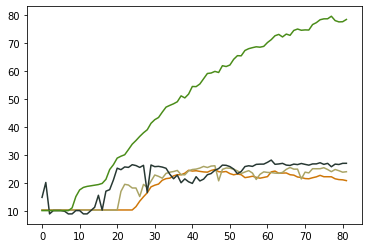

ROUND 81
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.105608


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.632571
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.039749

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.045198
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.146105
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016104

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.612488
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024420
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.393082

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.215075
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.166942
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.149428

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

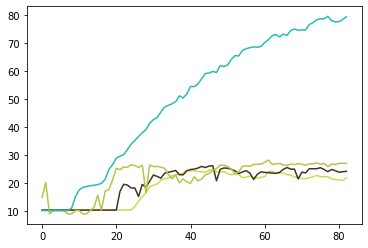

ROUND 82
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.059899


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.240478
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.141685

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.040905
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142073
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026149

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.271874
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.144270
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.626155

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.235556
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.216632
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.501561

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

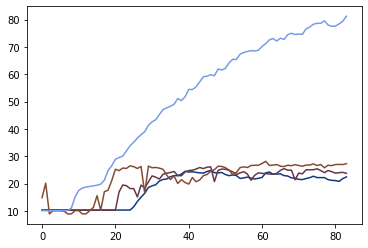

ROUND 83
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.044719


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.143718
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.306374

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.203894
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074910
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.042137

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.160035
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.243277
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.091782

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 24.5167543761287
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 5.85881

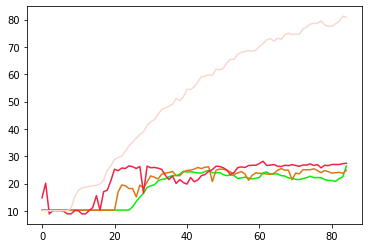

ROUND 84
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.002347


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054061
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.238405

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.199239
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.098165
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.366489

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.450365
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134614
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.842373

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.240275
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.598645
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.161120

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

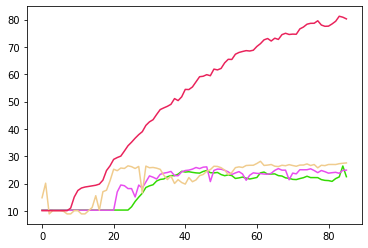

ROUND 85
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.259947


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084802
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.612094

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.171811
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052298
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.046435

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.650981
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.100419
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.121526

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.176572
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.145069
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.176849

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

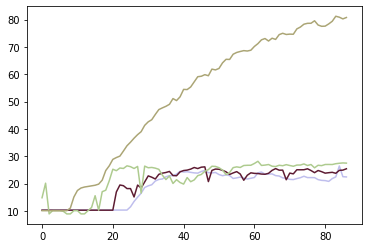

ROUND 86
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.052468


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121555
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.046882

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.440284
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.168358
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.232070

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.576737
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072693
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.166427

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.160740
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.152783
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.208228

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

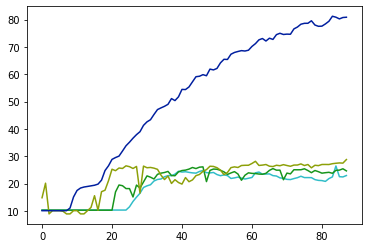

ROUND 87
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.110381


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058124
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.369446

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.945548
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102925
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008035

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.351779
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040330
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.425991

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.123942
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.243697
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.153981

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

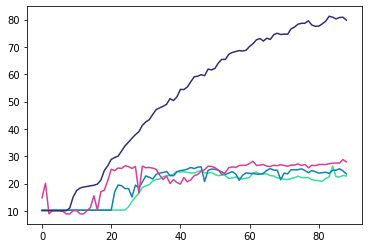

ROUND 88
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.002905


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151039
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.251970

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.073866
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076838
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.185235

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.673697
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015175
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.044117

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.175185
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024530
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.219870

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

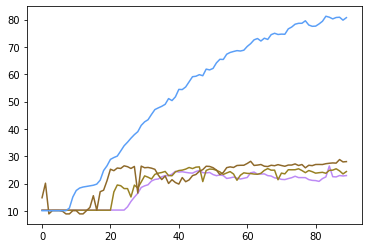

ROUND 89
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.020469


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.231723
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.042432

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.153850
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005101
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055413

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.447232
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074558
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.027997

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.172330
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.166808
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.123753

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

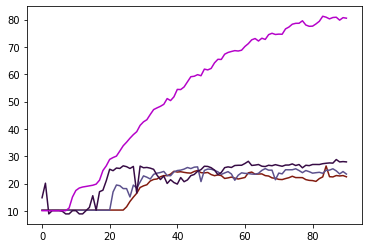

ROUND 90
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.123469


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011053
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.406286

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.844383
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064001
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002099

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.541183
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016386
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.100733

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.200146
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102854
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.313462

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

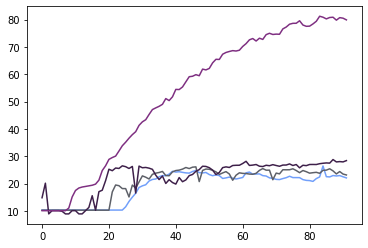

ROUND 91
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.028297


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076824
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.217516

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.187710
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.124942
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.516380

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.500761
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040061
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.047617

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.316197
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.136884
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.129720

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

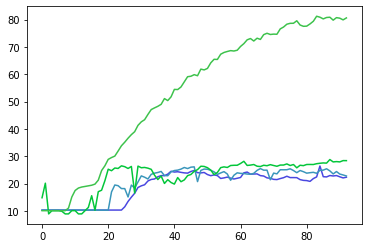

ROUND 92
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.109922


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.216089
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.114669

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.144366
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022961
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.419280

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.414152
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014908
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.198800

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.154821
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.147133
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.093211

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

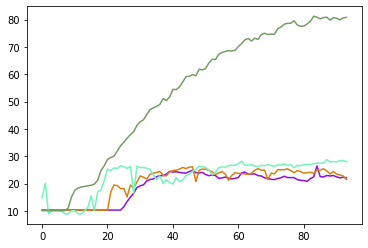

ROUND 93
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.978058


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093433
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.807527

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.993795
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009298
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.038178

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.590341
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092285
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.107192

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.276604
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.287159
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.563085

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

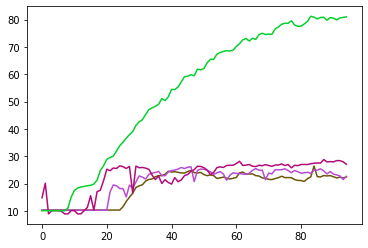

ROUND 94
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.052379


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049780
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.107522

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.190324
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071935
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.160607

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.760909
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121650
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.160906

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.238415
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.204597
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.259392

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

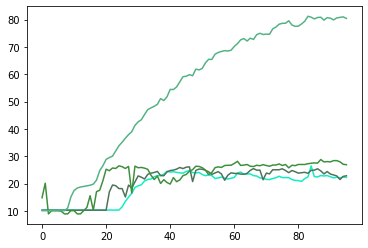

ROUND 95
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.116177


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117862
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.047854

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.105756
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005234
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013976

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.681356
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.580165
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.208260

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.218982
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.128472
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.220466

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

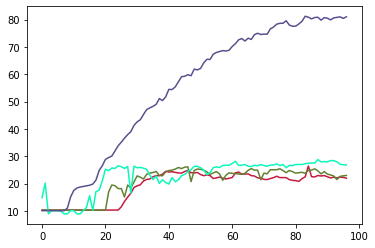

ROUND 96
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.127795


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.159481
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.324541

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.069194
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062974
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.404786

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.646778
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.208073
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.317520

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.237944
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.286406
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.334671

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

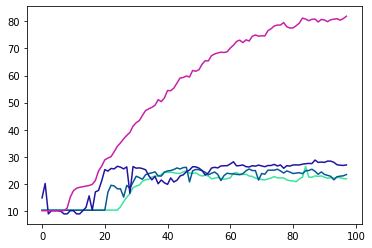

ROUND 97
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.276670


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032925
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.126716

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.152366
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016629
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.047440

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.472975
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.135055
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.147658

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.274651
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161799
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.070036

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

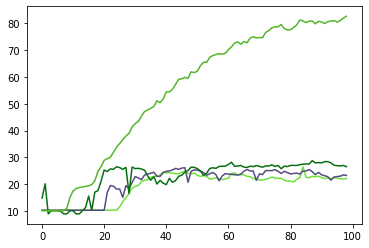

ROUND 98
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.985623


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.183120
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020563

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.099465
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021404
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.235396

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.559942
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076517
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.710779

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.198403
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062676
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.381530

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

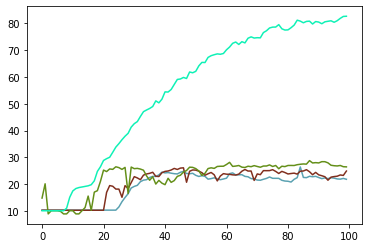

ROUND 99
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.180693


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008505
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.115890

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.825873
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103740
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.087368

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.341437
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134160
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.494055

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.132978
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.387838
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006421

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

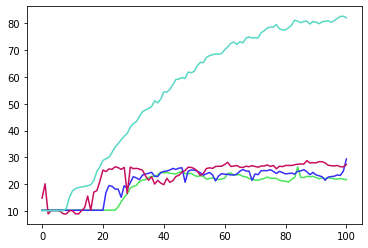

ROUND 100
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.012878


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081976
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.816568

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.092612
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068595
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000035

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.481120
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.330617
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.482976

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.292912
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017100
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001558

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

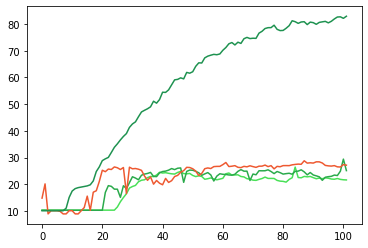

ROUND 101
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.043173


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094776
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.106290

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.124782
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000630
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.265375

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.576728
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.233693
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134301

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.131769
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048352
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.099024

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

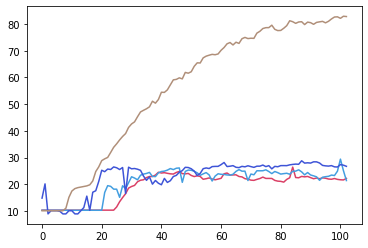

ROUND 102
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.101793


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.225955
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.163090

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.131319
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160411
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.317303

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.693014
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009572
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069782

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.232749
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030161
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.208344

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

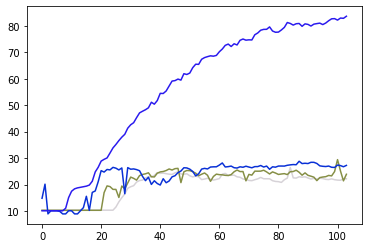

ROUND 103
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.036775


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.295850
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.390070

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.071388
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.427977
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005432

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.751246
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.148508
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051452

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.077810
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.097257
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.449368

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

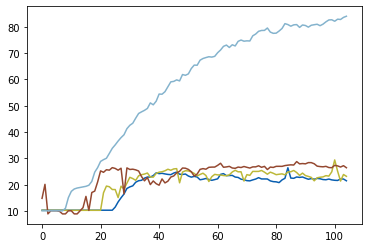

ROUND 104
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.161028


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071992
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022124

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.838181
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065405
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001193

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.497031
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031573
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.070781

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.205252
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018849
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000439

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

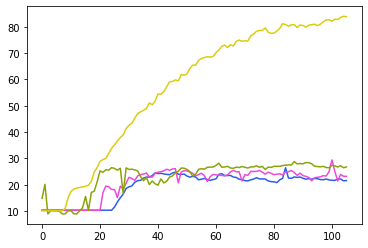

ROUND 105
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.104278


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.276107
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.129370

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.912473
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037765
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000376

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.393071
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033631
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.372391

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.146129
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.110236
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016128

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

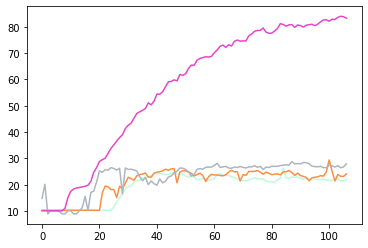

ROUND 106
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.066728


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.158510
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006729

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.917215
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005956
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.308901
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038542
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.317088

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.256750
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042296
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.329138

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

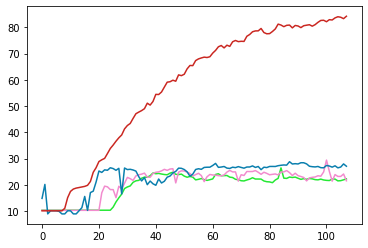

ROUND 107
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.103552


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.186902
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.173990

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.932892
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057433
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.039546

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.411469
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079305
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.531141

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.116399
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103790
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.195209

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

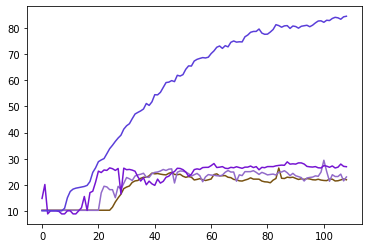

ROUND 108
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.124248


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.216763
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.123951

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.962457
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021104
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.125935

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.621583
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103013
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.418367

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.070626
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014857
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.075944

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

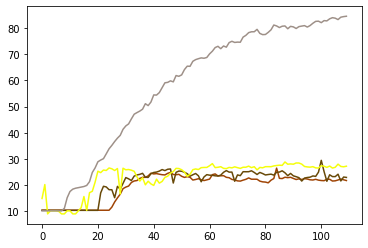

ROUND 109
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.142225


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113608
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.463679

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.121985
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.131132
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002948

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.430710
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018399
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001257

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.214662
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075924
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.522601

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

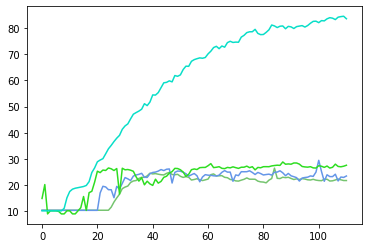

ROUND 110
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.077960


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048785
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.492048

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.004726
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082658
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.188682

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.505745
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051501
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036290

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.052346
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023066
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032222

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

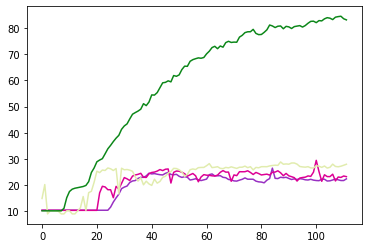

ROUND 111
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.011162


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180259
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.995518

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.045599
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011285
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.092750

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.280147
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003432
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002900

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.072547
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.193391
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.063597

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

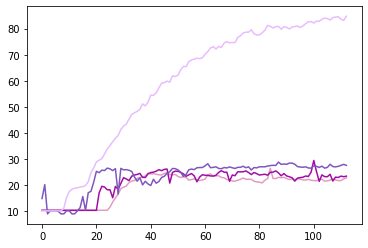

ROUND 112
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.002551


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.241565
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032962

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.102896
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022399
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.179268

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.391408
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132014
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.160347

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.157687
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.148627
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.012837

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

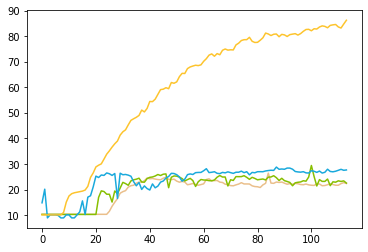

ROUND 113
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.026735


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005397
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.357357

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.993466
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.135613
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.588018

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.402352
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016140
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005102

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.073926
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104370
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.265470

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

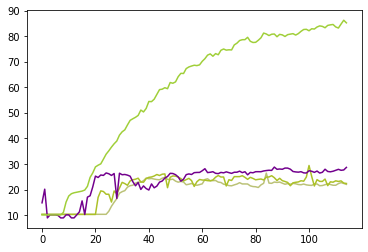

ROUND 114
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.115186


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061136
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.366721

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.071375
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066887
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.109920

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.397408
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039490
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.012671

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.143830
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041720
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036791

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

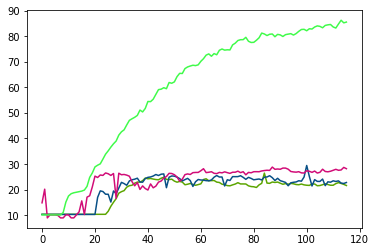

ROUND 115
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.169876


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056380
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.451072

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.853311
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004031
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.277298

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.224573
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024423
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.056621

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.116353
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087134
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001419

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

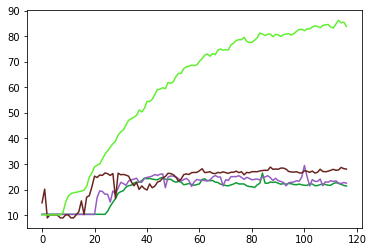

ROUND 116
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.114509


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.168432
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.025476

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.228758
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103997
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.735825

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.259070
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083509
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134421

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.112233
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099605
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051941

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

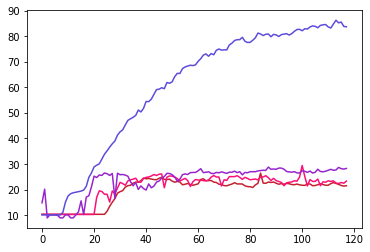

ROUND 117
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.168020


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016764
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.021997

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.002980
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005227
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.306204

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.559920
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003917
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.771076

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.109387
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021963
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041121

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

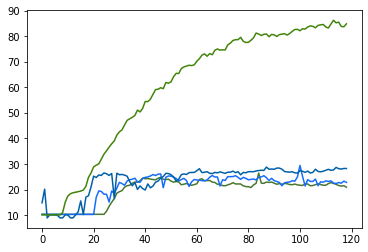

ROUND 118
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.106553


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012966
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.386644

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.048087
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018836
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.071373

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.511561
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056664
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.052103

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.104392
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033765
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.152725

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

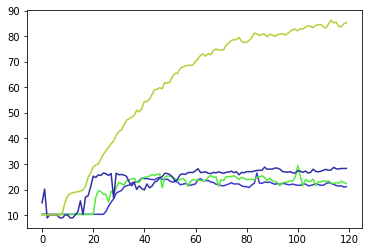

ROUND 119
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.026207


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.193485
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.126466

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.968239
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.189923
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.115436

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.640523
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048068
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.392269

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.214710
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103961
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051835

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

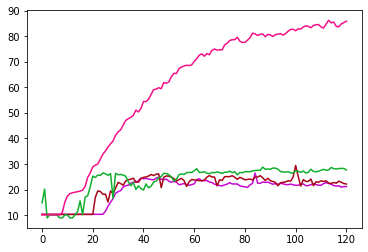

ROUND 120
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.070422


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069585
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.261098

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.980208
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005826
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.090723

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.381932
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037769
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.077844

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.027677
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059027
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.096662

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

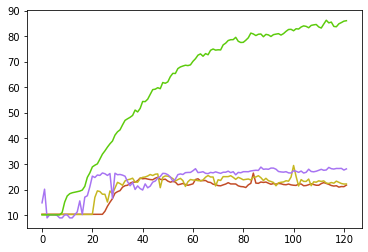

ROUND 121
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.957656


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072974
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.363479

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.946370
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.285208
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.012295

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.556898
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042714
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.660110

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.175155
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119476
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.156943

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

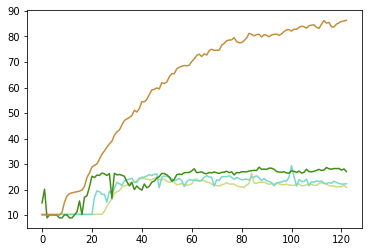

ROUND 122
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.885766


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.273144
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.047378

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.051307
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035341
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.259834

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.486658
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120820
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031210

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.094308
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060298
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000065

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

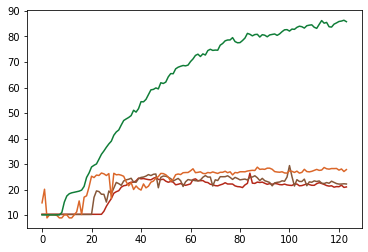

ROUND 123
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.089763


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.187224
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.045732

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.942485
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052897
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.139350

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.331625
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.440112
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.060769

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.976717
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027989
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.095459

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

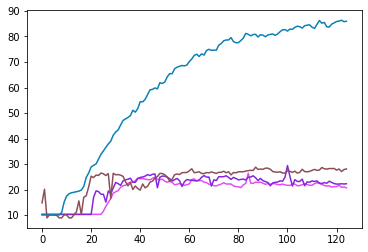

ROUND 124
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.955203


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.205929
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.124108

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.886806
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105287
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.793249

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.527845
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039296
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004596

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.145396
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091194
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.145394

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

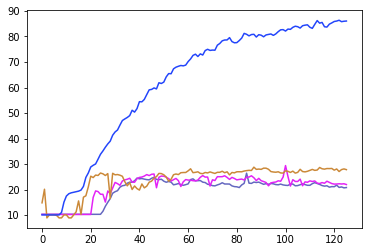

ROUND 125
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.005766


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104033
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.431347

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.154775
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181644
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.566088

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.363641
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034768
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004678

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.153880
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.205779
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.181845

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

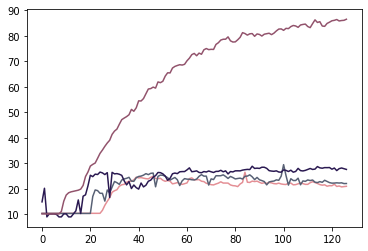

ROUND 126
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.967024


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077408
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086166

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.969093
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021861
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.133546

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.390703
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003652
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.559627

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.135572
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083494
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.196315

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

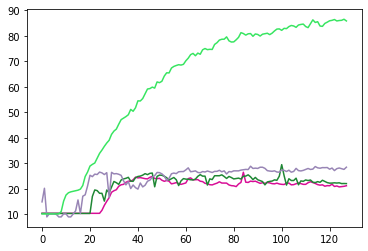

ROUND 127
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.907571


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019298
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.103350

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.009775
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079045
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.502467

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.295655
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.213307
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.227250

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.041610
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057282
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026907

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

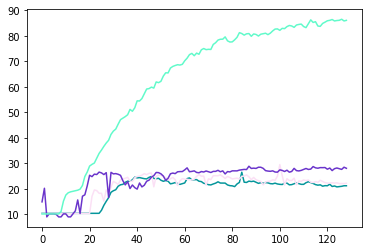

ROUND 128
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.102995


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138915
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059768

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.086996
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037920
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.097384

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.349383
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.100319
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.276547

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.029059
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093447
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.343973

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

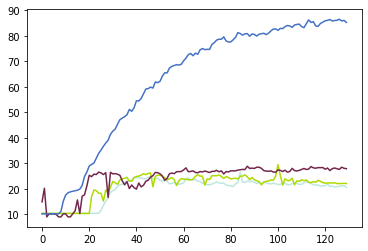

ROUND 129
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.976869


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052715
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.254578

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.037238
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012282
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015622

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.573584
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031923
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.242390

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.124077
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041239
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.295782

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

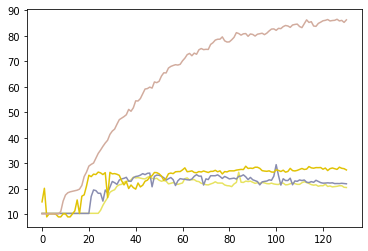

ROUND 130
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.976179


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085506
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134359

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.002828
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000298
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030100

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.378803
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034242
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009299

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.051833
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016278
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.052355

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

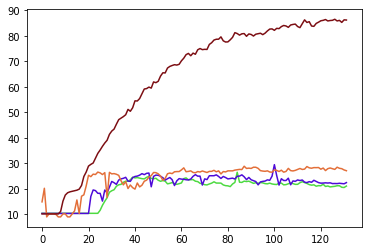

ROUND 131
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.017321


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.149326
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.033527

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.947700
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.254616
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.300458

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.332997
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107911
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002734

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.067657
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.167403
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.496770

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

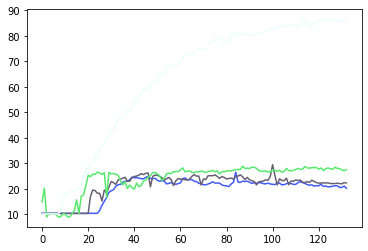

ROUND 132
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.192535


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134799
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.141541

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.992891
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197656
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051084

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.171104
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003154
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001283

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.026460
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042919
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.068467

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

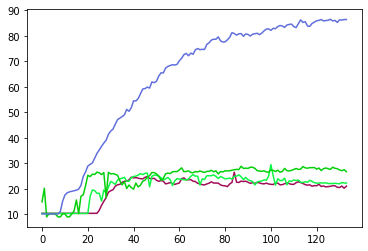

ROUND 133
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.007208


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085918
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059110

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.925849
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027757
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.052422

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.259569
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004042
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.139345

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.132850
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022168
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134838

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

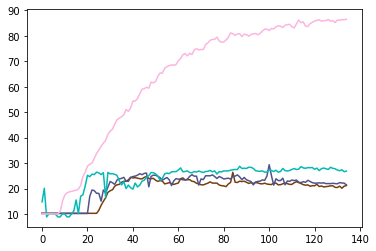

ROUND 134
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.885026


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142381
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.104510

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.026783
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045764
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008132

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.293803
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.412520
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.199168

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.927008
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023402
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059274

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

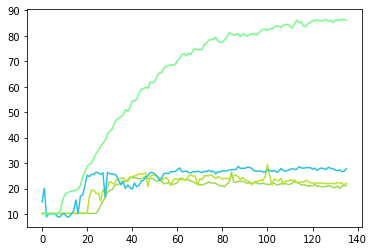

ROUND 135
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.857489


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091172
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.054761

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.970295
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037724
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.453181

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.351305
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039375
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.177568

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.094331
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120044
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.265861

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

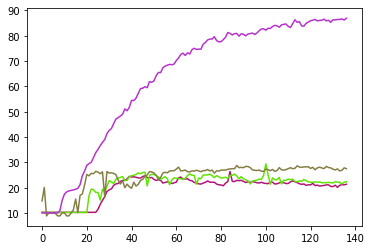

ROUND 136
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.999372


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.227731
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.131950

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.913454
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002031
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000059

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.375929
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019734
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000562

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.096907
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038611
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.121579

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

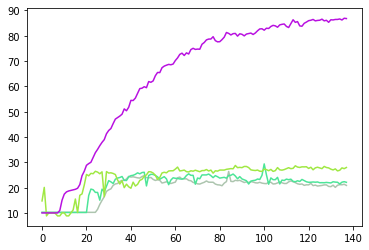

ROUND 137
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.826079


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.486378
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.237947

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.040137
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071010
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000491

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.386992
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032129
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001191

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.016894
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019658
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.673654

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

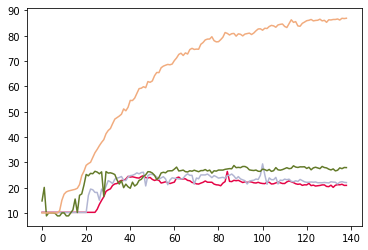

ROUND 138
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.994083


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102641
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.229306

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.053297
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012035
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.219505

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.453292
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036174
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006660

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.087983
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075709
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.082713

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

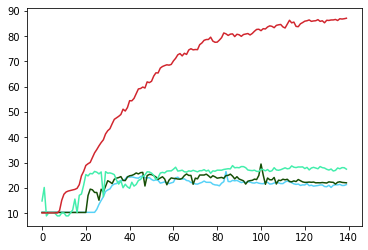

ROUND 139
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.987074


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129086
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.273828

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.947977
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053799
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.192559

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.326729
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.233393
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.085073

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.995483
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117274
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.345889

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

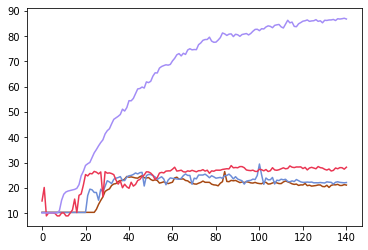

ROUND 140
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.980780


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067321
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026685

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.834601
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008102
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013818

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.291444
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048931
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.262392

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.042329
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028187
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.197457

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

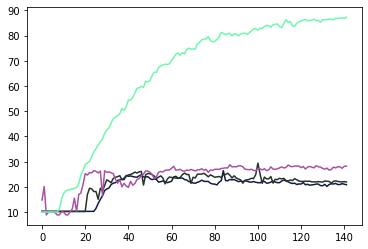

ROUND 141
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.023382


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.335913
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.065615

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.008507
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008528
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.037595

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.383464
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009433
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.975626

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.073459
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046965
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.124285

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

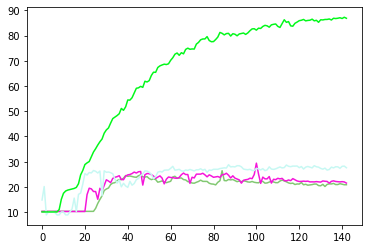

ROUND 142
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.912694


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104380
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.037116

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.884134
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.223848
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.369701

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.110317
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055580
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001502

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.968527
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050831
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026452

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

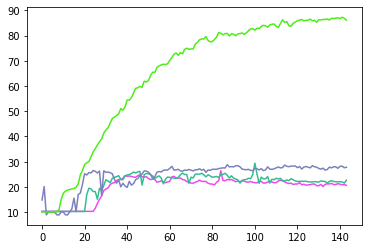

ROUND 143
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.196132


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165440
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.090316

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.922442
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089024
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.953384

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.456951
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033498
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017565

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.165467
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.146961
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029651

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

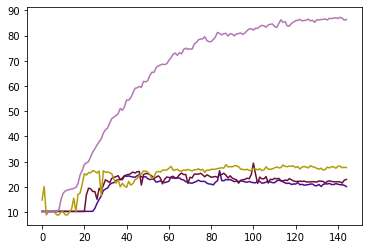

ROUND 144
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.944558


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088249
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.062141

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.074110
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005359
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000546

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.317036
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057051
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.149227

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.991861
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001309
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.543376

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

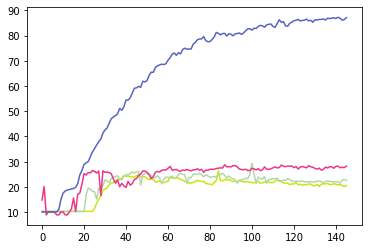

ROUND 145
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.969212


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065745
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.075176

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.871056
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016492
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.171127

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.338866
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077885
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.024029

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.037611
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084045
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.060033

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

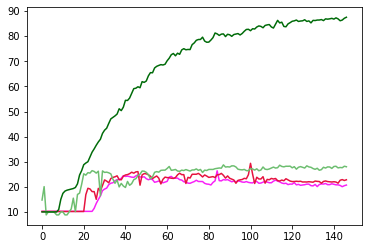

ROUND 146
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.106101


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.342124
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.529552

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.877936
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003619
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002033

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.315004
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014008
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.390508

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.024006
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010850
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.070711

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

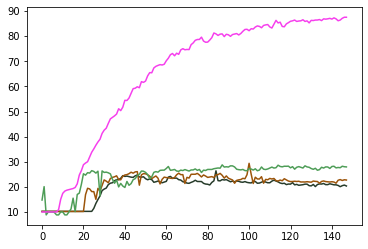

ROUND 147
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.842664


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.133892
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.165816

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.859866
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090207
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001241

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.158497
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013421
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.045749

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.989768
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042342
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134085

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

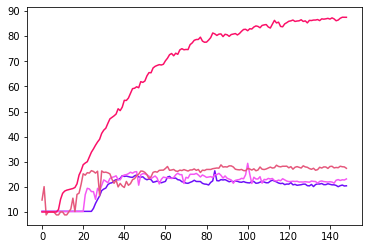

ROUND 148
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.987951


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.261939
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.157834

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.892117
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032408
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035818

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.275890
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047556
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.152312

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.062907
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015794
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.091558

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

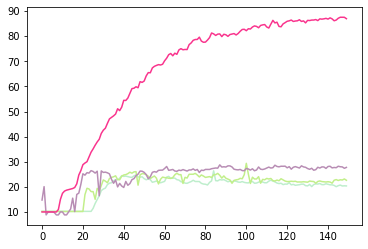

ROUND 149
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.814024
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050531
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.185883

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.024366
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050472
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.109460

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.424060
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034756
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.082633

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.985483
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016862
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

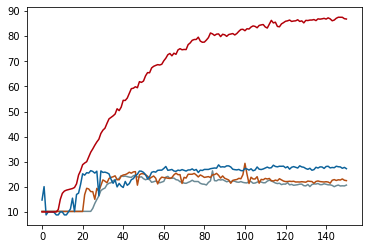

ROUND 150
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)


SNR= 26.934105738827533
Client: client5


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad


Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.920285
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050487
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.225086

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.914201
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069787
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.077330

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.290737
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.157984
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.464807

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.050405
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038541
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

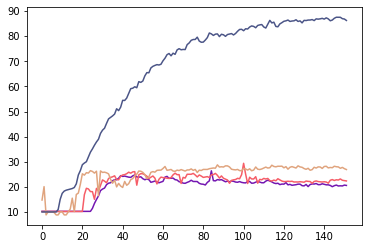

ROUND 151
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.810628


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.271746
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.091404

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.921238
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077136
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.082073

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.373705
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.555774
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.434211

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.007816
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081040
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.033789

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

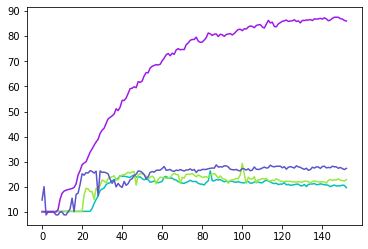

ROUND 152
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.943934


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101772
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.108603

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.944106
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104619
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.012525

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.237126
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.391407
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.319346

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.958932
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103654
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.212155

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

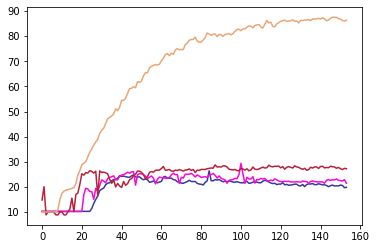

ROUND 153
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.824350


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.253285
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.094014

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.775767
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012698
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.237192

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.182603
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104808
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.431285

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.187613
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053945
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.065256

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

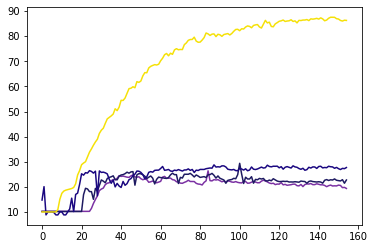

ROUND 154
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.015902


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058862
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.377346

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.737751
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009529
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.832741

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.077379
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028213
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013838

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.996463
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040274
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016336

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

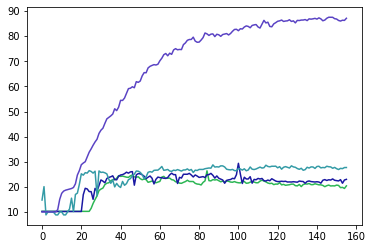

ROUND 155
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.844647


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.216406
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.119619

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.860189
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.095880
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.112482

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.266716
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101875
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.573235

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.064820
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029149
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000892

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

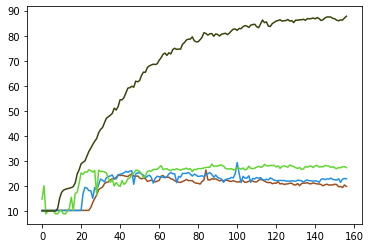

ROUND 156
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.829876


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077545
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.333730

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.977195
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197935
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026585

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.201594
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090168
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.052513

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.010293
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019778
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.833170

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

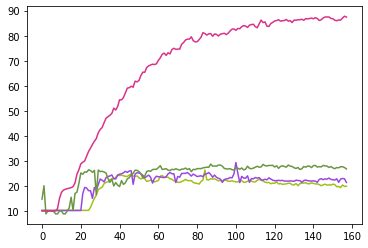

ROUND 157
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.925621


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105027
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.119386

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.041315
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024681
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.047732

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.308326
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.171916
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.590024

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.871736
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.157453
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.656788

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

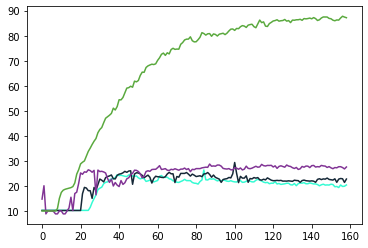

ROUND 158
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Client: client5


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.981268
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.106833
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.091833

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.869135
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060357
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.469836

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.419565
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042509
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.062865

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.006960
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029410
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

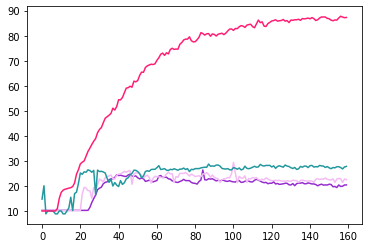

ROUND 159
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Client: client5


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.910215
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.143845
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.200375

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.798754
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000399
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.328834

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.210433
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.251732
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.123934

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.993586
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064286
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0

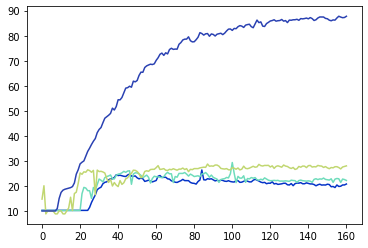

ROUND 160
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.051812


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048326
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.518570

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.066263
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041738
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.129440

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.322865
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.194246
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.371222

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.024631
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.158560
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007167

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

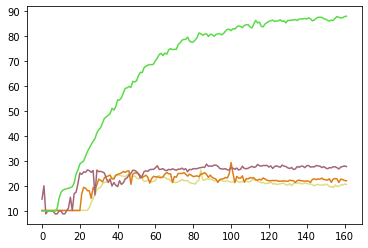

ROUND 161
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.127892


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142881
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.224362

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.827623
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000304
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004318

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.310743
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.337263
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.112391

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.885590
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037293
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.138698

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

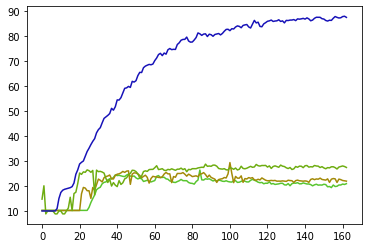

ROUND 162
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.944526


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151086
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.221962

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.946504
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006835
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.147743

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.310367
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.245175
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.738459

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.094302
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036054
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.025915

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

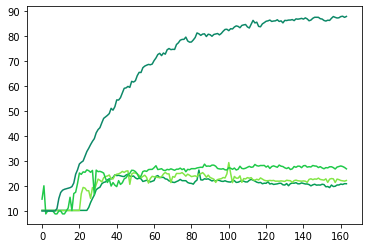

ROUND 163
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.851415


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020116
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.466325

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.864852
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083630
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036743

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.008189
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.178415
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.804071

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.900185
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.216477
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.288993

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

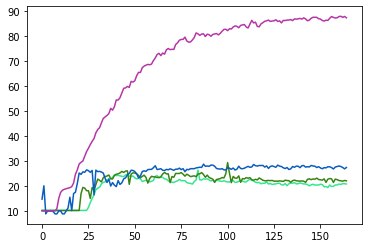

ROUND 164
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.940365


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012960
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.474917

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.897537
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.276573
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.060218

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.251300
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197340
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.204053

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.917869
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.256160
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.353717

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

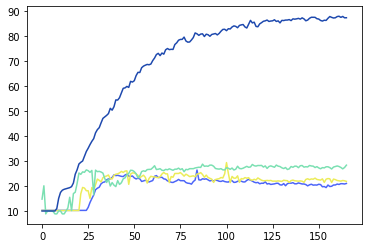

ROUND 165
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.899747


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.154843
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.132852

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.837785
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026545
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022851

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.137390
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.168942
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.340585

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.155479
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103687
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.843793

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

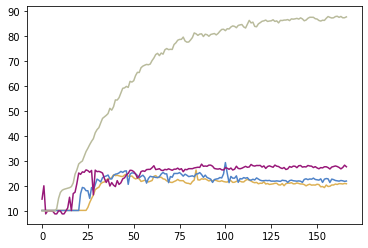

ROUND 166
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.063323


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.284957
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.329493

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.004669
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032042
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058163

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.235395
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042022
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.141087

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.059854
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086378
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.328528

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

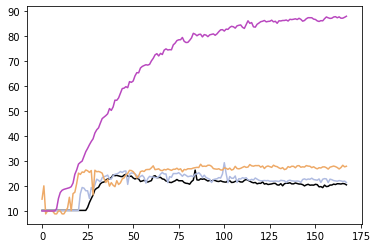

ROUND 167
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.033723


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.506878
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055317

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.874706
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006148
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.105549

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.221817
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025997
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.012665

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.985283
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084298
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.054960

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

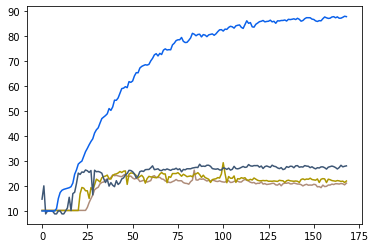

ROUND 168
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.947729


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165076
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.117925

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.002731
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001584
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041224

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.206490
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105708
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009279

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.952263
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013291
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.062803

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

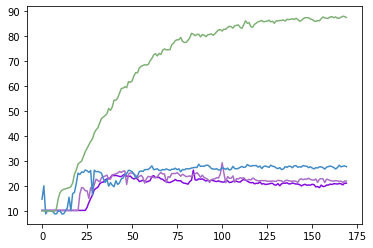

ROUND 169
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.985490


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.323228
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.242791

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.875040
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021069
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000019

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.177375
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076383
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043100

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.081257
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.141294
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.400275

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

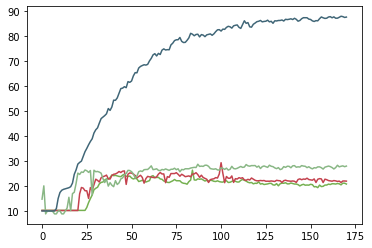

ROUND 170
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.975967


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042010
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.365009

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.793684
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.523231
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043939

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.305569
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093259
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.288603

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.025760
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103635
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.089881

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

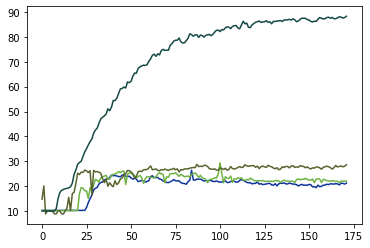

ROUND 171
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.877135


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005505
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.531702

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.787458
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.427907
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.537870

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.238428
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048502
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.132295

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.005768
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087459
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.010702

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

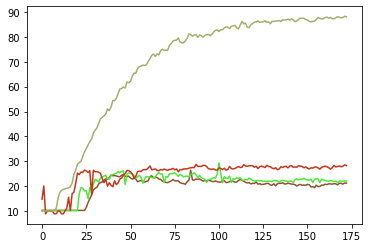

ROUND 172
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.848832


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.261110
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.292390

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.908030
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.063982
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035679

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.418185
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012481
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.052868

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.002791
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040116
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.209649

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

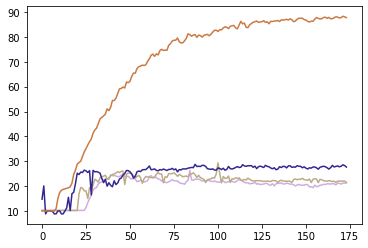

ROUND 173
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.880649


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.280935
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.048126

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.812093
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021240
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.332550

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.297391
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.443441
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.045872

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.058614
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029005
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002433

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

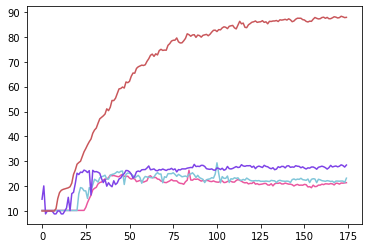

ROUND 174
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.940459


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.140026
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.081534

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.909482
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030259
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058895

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.285041
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.193950
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.045327

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.977480
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014473
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059016

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

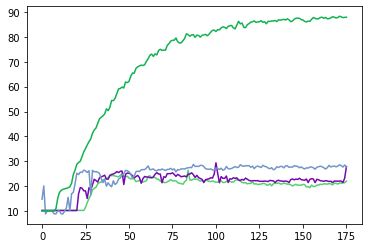

ROUND 175
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.966676


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.108541
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.158833

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.824214
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040120
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.853656

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.264171
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009467
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015012

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.004079
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.172459
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029533

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

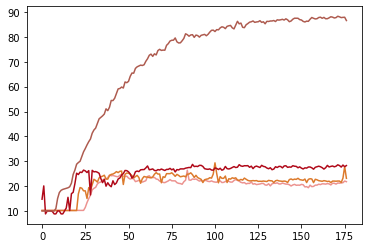

ROUND 176
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.016395


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.112993
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.183563

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.734467
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029905
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.475235

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.487702
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088852
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.114207

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.984641
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.205167
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030911

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

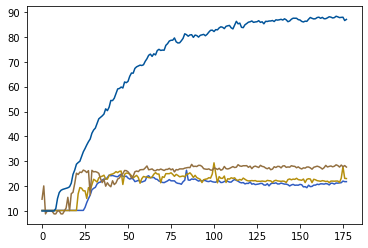

ROUND 177
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.743837


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039333
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031841

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.725124
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.690104
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.133713

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.276386
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036097
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018894

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.979011
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056087
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.073106

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

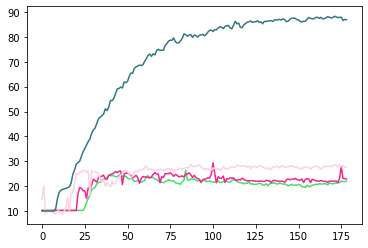

ROUND 178
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.949254


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022532
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.176285

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.740014
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.114221
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.398740

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.058522
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034456
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.291804

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 24.5167543761287
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 5.85881

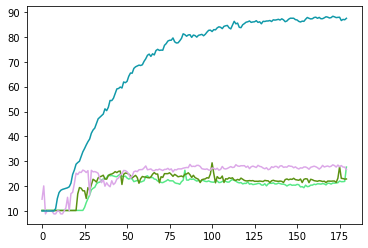

ROUND 179
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.886277


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.243093
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055327

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.866889
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058850
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.161310

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.166309
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.510105
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.139065

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.857535
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020898
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.130329

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

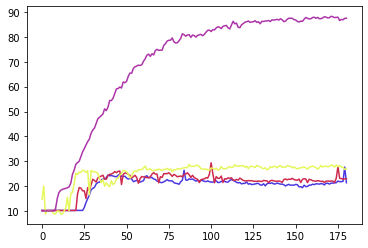

ROUND 180
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.911511


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102747
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.174805

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.909475
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050833
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.126719

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.053373
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.200748
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.901395

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.120613
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003323
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.078079

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

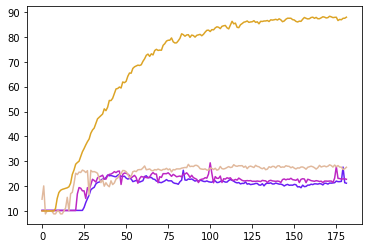

ROUND 181
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.845072


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026870
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.115419

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.713748
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.302553
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051965

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.237205
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050095
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.245250

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.900206
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.124055
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.056832

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

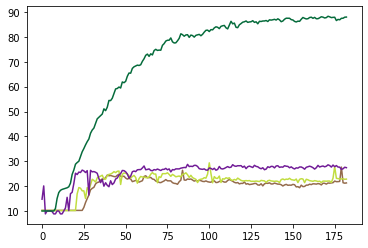

ROUND 182
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.868788


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039595
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.118810

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.817158
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109098
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.292716

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.430147
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.143788
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.321062

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.894367
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088500
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.085653

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

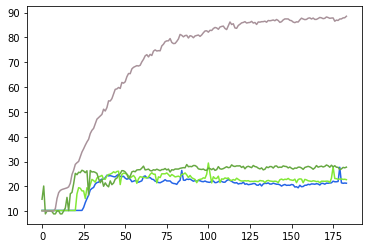

ROUND 183
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.811482


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011369
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.709874

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.672073
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011869
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030974

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.312084
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031442
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.325198

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.044575
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016088
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015219

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

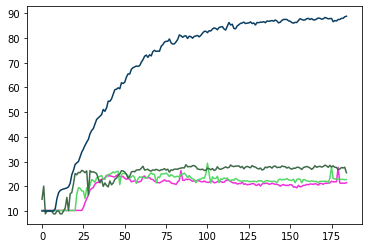

ROUND 184
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.880051


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034621
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.359264

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.768153
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052412
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.194415

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.424436
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091615
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.124749

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.834354
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013864
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.165144

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

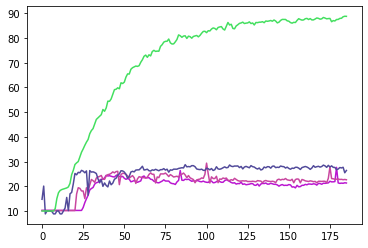

ROUND 185
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.816534


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083619
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.072034

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.947752
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093120
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005450

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.189061
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.266502
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.708500

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.876260
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.128190
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000861

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

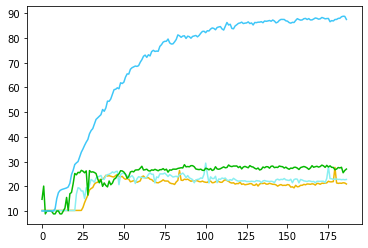

ROUND 186
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.885331


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077112
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.065146

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.909078
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022629
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.063242

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.266088
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.210291
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.237028

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.038270
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033738
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.028429

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

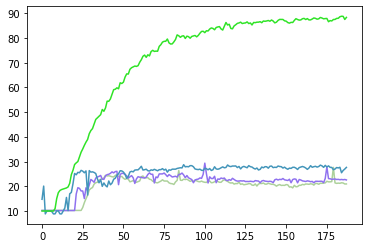

ROUND 187
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.965705


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053181
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.386390

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.971554
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160906
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.119208

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.305115
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.664651
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.903844

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.879732
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066946
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.513624

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

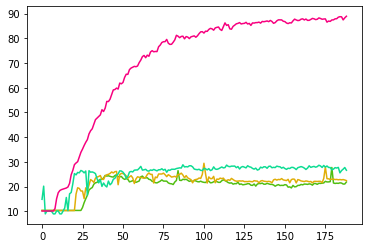

ROUND 188
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.862659


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179575
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.148473

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.960279
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.211736
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.205245

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.324829
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.297351
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.268573

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.918778
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073555
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.081663

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

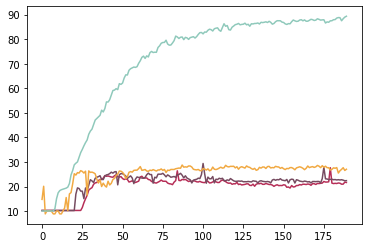

ROUND 189
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.986058


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018886
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.167341

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.750703
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109683
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.876078

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.358721
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137983
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.045040

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.049107
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021353
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016717

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

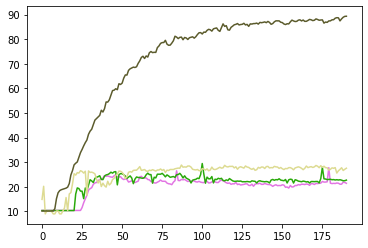

ROUND 190
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.900113


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.499755
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.336673

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.063131
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077739
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031269

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.277428
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.228145
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.316875

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.032396
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053518
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.089367

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

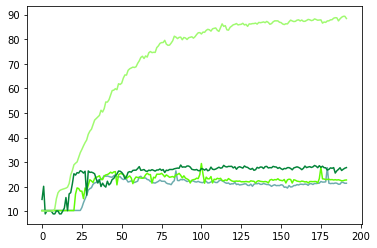

ROUND 191
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.948082


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060922
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.141125

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.674453
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011496
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.062483

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.257997
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.163944
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.323193

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.980009
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008888
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.311878

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

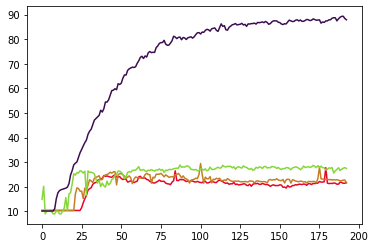

ROUND 192
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.871875


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078669
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.010468

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.917591
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.106269
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.088420

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.267891
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083832
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019910

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.860597
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011266
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023600

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

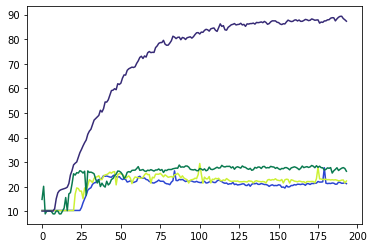

ROUND 193
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.852305


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042705
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.142400

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.876260
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025348
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.253487

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.184412
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.159823
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.122166

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.986498
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043027
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.098157

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

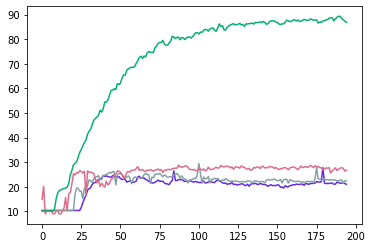

ROUND 194
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.950588


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077316
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.064294

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.970235
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.156770
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036030

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.315730
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067089
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.361928

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.952636
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014207
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.021829

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

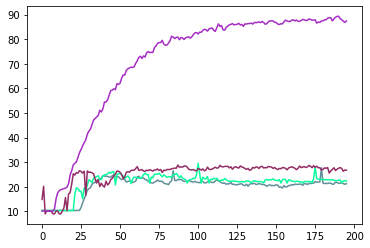

ROUND 195
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.040102


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.144862
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.125086

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.794557
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022519
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.071739

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.278457
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.511223
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.199976

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.937906
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027424
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.453114

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

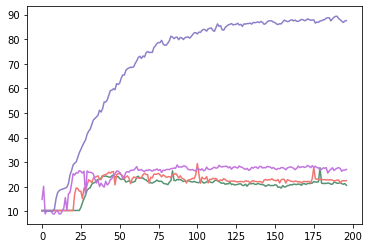

ROUND 196
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.806957


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070019
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.196859

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.644881
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129251
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.114550

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.557182
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.143859
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055469

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.162542
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.106289
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.044694

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

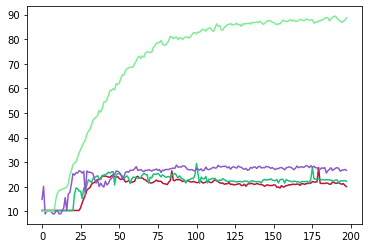

ROUND 197
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.951140


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036175
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.095195

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.911482
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.450550
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.142315

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.368337
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056875
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.353696

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.845953
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045566
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.112064

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

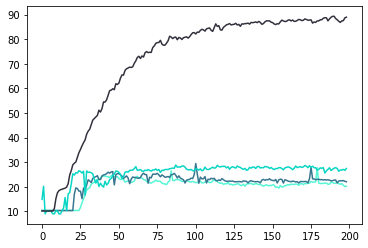

ROUND 198
0.11540000000001499
Power Allocated= 0
CSI= 0.04016189190759112
SNR= 25.044566568674192
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.560559310035942
CSI= 0.9050167252607304
SNR= 26.934105738827533
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.825929


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.147234
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.117692

Power Allocated= 7.324599698408403
CSI= 0.7457613348954174
SNR= 24.09849004350459
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.884028
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.110631
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.048462

Power Allocated= 6.999758293690703
CSI= 0.6003291106939019
SNR= 24.836026974396567
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.357010
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064682
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.200040

Power Allocated= 6.1163849697504915
CSI= 0.39229127320973844
SNR= 31.10882841550999
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.799089
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037412
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.276348

Power Allocated= 0
CSI= 0.10333520302510513
SNR= 

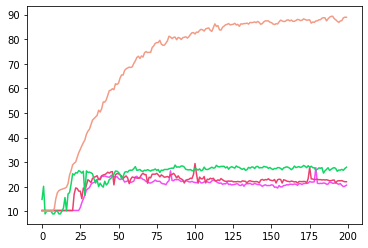

ROUND 199


In [14]:
for client in clients: #give the model and optimizer to every client
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    #client['model'] = torch.quantization.quantize_dynamic(
    #client['model'],  # the original model
    #{torch.nn.Linear},  # a set of layers to dynamically quantize
    #dtype=torch.fp)  # the target dtype for quantized weights
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)

final_acc=[]
final_loss=[]
    
for fed_round in range(args.rounds):
    overall=Net()
    if(fed_round==0): #fed_round==0
        arranged_clusters,head_snr_list=cluster_former(args.numclusters,args.clients)
        temp=deepcopy(arranged_clusters)
        temp2=deepcopy(head_snr_list)
    else:
        #print(temp)
        arranged_clusters=deepcopy(temp)
        head_snr_list=deepcopy(temp2)
#     print(arranged_clusters)
    
    no=1
    heads_list=[]
    weights=[]
    weight_head_list=[]
    head_acc=[]
    head_loss=[]
    for cluster in arranged_clusters:
        
        head=cluster['Cluster Head']
        members=cluster['Members']
        snrs=cluster['SNR']
        csis=cluster['CSI']
        weights.append(sum(snrs))
        weight_head_list.append([head,sum(snrs)])
        new_members=[]
        
        for ij in members:
        #print(ij)
            cl_no=int(ij[6:])
            new_members.append(clients[cl_no-1])
#         print(head)
        head=clients[int(head[6:])-1]
        cluster['Members']=new_members
#         print(head)

        smallmu1=0
        gsmall1=3.402823466E+38 
        
        #water filling algorithm
        mu=1e-15
        while(mu<=1):
            g1=0
            pn1=0
            for jj in csis:
                pn=max(1/mu-1/jj,0)
                g1+=math.log(1+pn*jj) #capacity of a channel (shannon's law)
                pn1+=pn
            g=g1-mu*(pn1-P*30)
            if(g<gsmall1):
                smallmu1=mu
                gsmall1=g
            mu+=0.00002
        
        print(smallmu1)
        good_mem=[]
#         print(len(snrs))
#         print(len(csis))
#         print(len(new_members))
        index=0
        for client in new_members:
            goodchannel=ClientUpdate(args, device, client,key_np,key,snrs[index],csis[index],smallmu1,head)
            index+=1
            if(goodchannel):
                good_mem.append(client)
        
        head['model']=averageModels(head['model'], good_mem)
        arr=test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)
        ac=arr[0]#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[0]
        no+=1
        heads_list.append(head)
        head_acc.append(ac)
        head_loss.append(arr[1])#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[1])
    
    final_acc.append(head_acc)
    final_loss.append(head_loss)
    fig,ax=plt.subplots()
    clor = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(args.numclusters)]
    #ax.plot([i for i in range(fed_round)],head_acc[0])
    for jj in range(0,args.numclusters):
        
        ax.plot([i for i in range(len(final_acc))],[final_acc[j][jj] for j in range(len(final_acc))], color = clor[jj])
        
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][0] for j in range(len(final_acc))], color ="red")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][1] for j in range(len(final_acc))],color ="blue")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][2] for j in range(len(final_acc))],color ="green")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][3] for j in range(len(final_acc))],color ="black")
    #ax.plot([i for i in range(len(final_acc))],head_acc[1], fed_round, color ="blue")
    #ax.plot([i for i in range(len(final_acc))],head_acc[2], fed_round, color ="green")
    #ax.plot([i for i in range(len(final_acc))],head_acc[3], fed_round, color ="black")
    
    
    plt.show()
    weightsum=sum(weights)
    
    weights[:] = [x / weightsum for x in weights]
    for aah in range(len(weight_head_list)):
        weight_head_list[aah][1]=weights[aah]
    final_heads,nets=decentralized(heads_list,head_snr_list,weight_head_list)
    
    for head in range(len(final_heads)):
        for cluster in arranged_clusters:
            head1=cluster['Cluster Head']
            if(head1==final_heads[head]['hook'].id):
                for mem in cluster['Members']:
                    mem['model'].load_state_dict(nets[head].state_dict())
    print("ROUND",fed_round)

In [15]:
print(final_acc)

[[10.32, 10.28, 14.82, 10.09], [10.32, 10.28, 20.15, 10.09], [10.32, 10.28, 8.92, 10.09], [10.32, 10.28, 10.1, 10.09], [10.32, 10.28, 10.1, 10.09], [10.32, 10.28, 10.1, 10.09], [10.32, 10.28, 9.87, 10.09], [10.32, 10.28, 8.91, 10.09], [10.32, 10.28, 8.92, 11.06], [10.32, 10.28, 10.1, 15.1], [10.32, 10.28, 10.1, 17.48], [10.32, 10.28, 8.92, 18.38], [10.32, 10.28, 8.92, 18.75], [10.32, 10.28, 10.1, 18.96], [10.32, 10.28, 11.28, 19.18], [10.32, 10.28, 15.57, 19.4], [10.32, 10.28, 10.25, 19.81], [10.32, 10.28, 17.04, 21.26], [10.32, 10.28, 17.58, 24.77], [10.32, 10.28, 21.07, 26.52], [10.32, 10.28, 25.26, 28.86], [10.32, 16.95, 24.72, 29.53], [10.32, 19.49, 25.7, 30.06], [10.32, 19.23, 25.54, 31.92], [10.32, 18.18, 26.5, 33.84], [11.51, 18.17, 26.19, 35.15], [13.47, 15.11, 25.53, 36.61], [15.04, 19.46, 26.28, 37.91], [16.47, 18.38, 16.53, 38.99], [18.58, 20.6, 26.4, 41.3], [19.18, 22.82, 25.8, 42.59], [19.58, 22.34, 25.91, 43.37], [20.95, 21.68, 25.65, 45.29], [21.52, 23.39, 25.22, 47.08],